# Creación de modelos de puntuación del Riesgo de Impago

En esta aplicación implementaremos un modelo de puntuación de riesgo de impago siguiendo la metodología  que hemos analizado en la presentación de clase (selección de variables mediante valor de la información, tramificación de variables continuas, agrupación de categorías, transformación woe de variables, estimación de modelos de regresión logística, ....)

Existen diferentes librerías que incorporan funciones con los diferentes procedimientos ya programados que nos facilitan mucho la tarea. Una de estas librerías es `scorecardpy` [librería scorecardpy](https://pypi.org/project/scorecardpy/) que estima tarjetas de puntuación *lineales* utilizando regresiones logísticas. Esta librería nació inicialmente en R, y lamentablemente la versión de Python da algunos errores de adaptación a las últimas versiones de Pandas. Su desarrollador remite a utilizar la versión estable de R (librería en R 'scorecard'). 

Así que en su lugar de esta librería utilizaremos la librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/) que en realidad recoge (y en mi opinión mejora) la principal función de la librería `scorecardpy`  

## Creación de un entorno e instalación de librerías 



In [1]:
# Podemos Crear un nuevo entorno de trabajo (mejor desde el terminal)
#! conda create -n risk_env
#! conda activate risk_env
#! conda config --env --add channels conda-forge
#! conda config --env --set channel_priority strict

# Instalamos la librería pandas y seaborn en el nuevo entrono desde conda (sólo la primera vez, utilizaré el terminal (con jupiter debo utilizar !))
# conda install pandas
# conda install seaborn

# Instalamos la librería optbinning y scorecardpy (sólo la primera vez)
# ! pip install scorecardpy # NOOO esta no la intaleis porque no es estable
# ! pip install optbinning


#Cargo o importo pandas, numpy, Matplotlib, 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Para el análisis descriptivo inicial de contraste de asociación importo el test Chi2 y el anova 
from scipy.stats import chi2_contingency
from scipy.stats import f_oneway

# Cargaríamos la librería scortecardpy si fuese estable (que no lo es)
#import scorecardpy as sc


# Librería para hacer la tramificación, agrupación y transformación WOE
from optbinning import Scorecard, BinningProcess, OptimalBinning
from optbinning.scorecard import plot_auc_roc, plot_cap, plot_ks,ScorecardMonitoring

# Scikit-learn para dividir la muestra y para estimar el modelo de regresión logística (sólo si no se quiere utilizar
# la función optbinning.scorecard que ya lo incropora)
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import balanced_accuracy_score

# Preparación de los datos sobre Créditos que utilizaremos en la práctica **germancredit**
## Carga de los datos 
En nuestra práctica utilizaremos una de las bases más utilizadas en los ejemplos de Puntuación de riesgo de crédito porque fue una de las primeras en ofrecerse en abierto. Corresponden a una base de datos de créditos de un Banco Alemán, y son datos reales, aunque muy antigüos de principios de los 90. Eso significa que las magnitudes de cantidades (expresadas en Marcos Alemanes), sean de difícil interpretación para el día de hoy. Sin embargo el signo y el sentido de las variables utilizadas para predecir el riesgo de impago de los futuros clientes permanece todavía de plena utilidad.

Los datos originales pueden descargarse del repositorio la UCI Machine Learning Repositoy [datos de Créditos alemanes](https://archive.ics.uci.edu/ml/datasets/Statlog+(German+Credit+Data)).  Para esta clase, sin embargo, os he preparado tres conjuntos de datos:

- "Clientes Aceptados": Conjunto de clientes a los que se aceptó su solicitud y se les concedió un crédito (fichero 'Aceptados.csv')
- "Clientes Rechazados": Conjunt de clientes a los que se denegó o rechazó su solicitud y por tanto no se les concedió el crédito (fichero 'Rechazados'.csv)
- "Nuevas solicitudes": Conjunto de nuevas solicitudes y que hay que evaluar o puntuar


In [2]:
# Cargamos los datos germancredit que están precargados en la librería scorecardpy
dt=pd.read_csv('Aceptados.csv')   # ACEPTADOS
Rechazados=pd.read_csv('Rechazados.csv')   # RECHAZADOS
Nuevos=pd.read_csv('Nuevos.csv')  # NUEVAS SOLICITUDES


# **Primera Etapa: Construcción del primer modelo sólo con los "Aceptados"**

Para construir el primer modelo necesitamos datos sobre la variable objetivo, la variable evento, que en nuestro caso es la variable Impago. Esta información sólo está disponible para los solicitantes a los que se les concedió el préstamo y que acabaron convirtiéndose en clientes. Siguiendo el comportamiento de estos clientes a lo largo de la ventana de observación se ha podido crear la variable objetivo Impago (y=1 cuando ha habido impago; y=0 cuando no ha habido impago)

## Descripción inicial de los datos sobre Créditos derivados de la práctica **germancredit** con Aceptados
Vamos a hacer una descripción inicial de los datos


In [3]:
#Información del Contenido
dt.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 786 entries, 0 to 785
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype 
---  ------                                                    --------------  ----- 
 0   status.of.existing.checking.account                       786 non-null    object
 1   duration.in.month                                         786 non-null    int64 
 2   credit.history                                            786 non-null    object
 3   purpose                                                   786 non-null    object
 4   credit.amount                                             786 non-null    int64 
 5   savings.account.and.bonds                                 786 non-null    object
 6   present.employment.since                                  786 non-null    object
 7   installment.rate.in.percentage.of.disposable.income       786 non-null    int64 
 8   personal.status.and.sex       

## Variable objetivo: creditability

 La variable **y** es la variable evento que en nuestro caso codificamos como **impago** de cada cliente, es la variable a predecir.    
 Toma originalmente dos valores (0:Buen Cliente y 1:Mal Clioente)

In [4]:
dt['y'].value_counts()


y
0    630
1    156
Name: count, dtype: int64

In [5]:
dt['y'].value_counts(normalize=True)

y
0    0.801527
1    0.198473
Name: proportion, dtype: float64

In [6]:
# Guardo los valores para su uso posterior 
yT_0 = dt['y'].value_counts(normalize=True)[0]
yT_1 = dt['y'].value_counts(normalize=True)[1]
print(yT_0, yT_1)

0.8015267175572519 0.1984732824427481


**Fíjate que tenemos un 20% aprox de malos clientes (aceptados)** 

## Variables Predictoras o explicativas

Las 20 restantes variables del data frame (7 numéricas y 13 categóricas) son los atributos o características observadas de esos clientes que se utilizarán para predecir la probabilidad de que los clientes cometan un impago de sis créditos, esto es, de que sean malos clientes. La descripción de estas 20 variables es la siguiente:

In [7]:
#  - Attribute 1: (qualitative) **Status of existing checking account o cuenta corriente** 
#   - A11 : ... < 0 DM 
#   - A12 : 0 <= ... < 200 DM 
#   - A13 : ... >= 200 DM / salary assignments for at least 1 year 
#   - A14 : no checking account 

#- Attribute 2: (numerical) **Duration in month** 
  
#  - Attribute 3: (qualitative) **Credit history**  
#     - A30 : no credits taken/ all credits paid back duly (devultos sin mora)
#     - A31 : all credits at this bank paid back duly 
#     - A32 : existing credits paid back duly till now 
#     - A33 : delay in paying off in the past 
#     - A34 : critical account/ other credits existing (not at this bank) 

# - Attribute 4: (qualitative) **Purpose** 
#     - A40 : car (new) 
#     - A41 : car (used)
#     - A42 : furniture/equipment
#     - A43 : radio/television
#     - A44 : domestic appliances
#     - A45 : repairs
#     - A46 : education
#     - A47 : (vacation - does not exist?)
#     - A48 : retraining
#     - A49 : business
#    - A410 : others 

# - Attribute 5: (numerical) **Credit amount** 
  
# - Attribute 6: (qualitative) **Savings account/bonds** 
#    - A61 : ... < 100 DM
#    - A62 : 100 <= ... < 500 DM
#    - A63 : 500 <= ... < 1000 DM
#    - A64 : .. >= 1000 DM 
#    - A65 : unknown/ no savings account 

# - Attribute 7: (qualitative) **Present employment since** 
#     - A71 : unemployed 
#     - A72 : ... < 1 year 
#     - A73 : 1 <= ... < 4 years 
#     - A74 : 4 <= ... < 7 years 
#     - A75 : .. >= 7 years 

# - Attribute 8: (numerical) **Installment rate in percentage of disposable income** 
  
#  - Attribute 9: (qualitative) **Personal status and sex** 
#     - A91 : male : divorced/separated
#     - A92 : female : divorced/separated/married
#     - A93 : male : single
#     - A94 : male : married/widowed
#     - A95 : female : single 

# - Attribute 10: (qualitative) **Other debtors / guarantors**
#    - A101 : none
#    - A102 : co-applicant
#    - A103 : guarantor 

# - Attribute 11: (numerical) **Present residence since**
  
# - Attribute 12: (qualitative) **Property**
#     - A121 : real estate
#     - A122 : if not A121 : building society savings agreement/ life insurance
#     - A123 : if not A121/A122 : car or other, not in attribute 6 
#     - A124 : unknown / no property 

# - Attribute 13: (numerical) **Age in years** 
  
# - Attribute 14: (qualitative) **Other installment plans** Otros pagos por plazos
#      - A141 : bank
#      - A142 : stores
#      - A143 : none 

# - Attribute 15: (qualitative) **Housing**
#      - A151 : rent 
#      - A152 : own
#      - A153 : for free 

# - Attribute 16: (numerical) **Number of existing credits at this bank**
  
# - Attribute 17: (qualitative) **Job**
#   - A171 : unemployed/ unskilled - non-resident
#   - A172 : unskilled - resident
#   - A173 : skilled employee / official
#   - A174 : management/ self-employed/highly qualified employee/ officer 

# - Attribute 18: (numerical) **Number of people being liable to provide maintenance for** 
  
# - Attribute 19: (qualitative) **Telephone**
#   - A191 : none
#   - A192 : yes, registered under the customers name 

# - Attribute 20: (qualitative) **foreign worker** 
#   - A201 : yes 
#   - A202 : no 



## Analisis univariante y de asociación con la variable objetivo 

## ¿Qué comprobar en el análisis descriptivo inicial?

### **Análisis univariante**

1- **Tipos de variables**. Todas las variables categóricas (factores) están bien identificadas?


Para el análisis univariante es importante realizar un análisis gráfico con el **Histograma de Frecuencias**

2- **Límites de las variables cuantitativas** Valores numéricos fuera de rango ¿Hay alguna limitación sobre el rango de alguna variable que no se cumpla? 

3- **Niveles de las variables cualitativas**, Valores mal codificados ¿los niveles de las variables cualitativas tienen sentido? ¿Hay missings no declarados tipo -1, 99999? Las categorías de las nominales son las que deben? 

4- **Variables nominales o categóricas o factores con categorías minoritarias**.Frecuencia de las categorías de las variables cualitativas.  Las categorías con baja representación puede causar muchos problemas en los modelos por falta de base muestral para la estimación de los parámetros correspondientes a la pertenencia a esa categoría. Por ello, es conveniente echar un vistazo y recodificar las vairables uniendo categorías muy poco representativas con otras cuya unión tenga algún sentido (tienen comportamiento similar frente a la objetivo, la variable tiene caracter ordinal por lo que la unión con mayor sentido sería hacia categorías adyacentes..).
Es imprescindible que todas los niveles de las variables cualitativas estén bien representados pues, de lo contrario, se podrían detectar patrones que no fueran extrapolables al estar basados en muy pocas observaciones.
Por ello, se debe verificar que la frecuencia de todas ellas sea superior al 2-5 % (el porcentaje exacto depende del numero de observaciones del conjunto de datos) Yo prefiero que haya variabilidad suficiente: NO debe haber categorías con menos de un 5% de representación).

5 **Variabilidad suficiente de las variables numéricas** Por encima de un 5% de valores distintos


Con estas cosas ya arregladas, nos vamos a los dos grandes "caballos de batalla" de la depuración. 

6- **Outliers**. Incidencia y tratamiento: pasar a missing, eliminar o winsorizar (reemplazarlos con los valores no atípicos más cercanos)







7- **Análisis de las variables/casos ausentes (Missings)**. Incidencia y tratamiento   
   - **Imputación** por valores validos (0-5%):  simple por media, mediana, aleatorio, imputación por modelos
   - **Recategorizacion** (5%- 50%) de los valores missing como una categoría valida.
   - **Eliminar** columnas u observaciones (superior al 50 %) Cuando en una variable hay mas de la mitad de los datos faltantes, es recomendable rechazarla al inicio del proceso, pues carece de suficiente informacion.
  

### **Análisis Bivariante**
**Después del análisis Univariante se realiza el Análisis Bivariante, entre cada una de las potenciales variables explicativas y la Variable objetivo** 

a. Tablas de contigencia Chi2 (¿discretizar variables continuas V de Cramer o Chi2 dnormalizado entre 0 y 1,, independientes y totalmente dependientes respectivamente))
b. Tablas de correlaciones 
c. Tablas Pivote (test de diferencia de medias)

c) Métodos gráficos:
  - Gráficos de dispersión
  - Diagrama de Cajas o boxplot (o diagrama de barras)
  - diagrams de mosaicos



***


## Análisis exploratorio inicial de las **variables categóricas**

Comenzamos con el análisis de las variables discretas

In [8]:
dt.describe(include='object')

,status.of.existing.checking.account,credit.history,purpose,savings.account.and.bonds,present.employment.since,personal.status.and.sex,other.debtors.or.guarantors,property,other.installment.plans,housing,job,telephone,foreign.worker
count,786,786,786,786,786,786,786,786,786,786,786,786,786
unique,4,5,10,5,5,4,3,4,3,3,4,2,2
top,no checking account,existing credits paid back duly till now,radio/television,... < 100 DM,1 <= ... < 4 years,male : single,none,"car or other, not in attribute Savings account...",none,own,skilled employee / official,none,yes
freq,341,416,230,450,263,422,710,268,645,570,487,467,753


### **status.of.existing.checking.account**

In [9]:
dt['status.of.existing.checking.account'].value_counts(normalize=True,dropna=False).round(3).sort_index()

status.of.existing.checking.account
... < 0 DM                                                0.246
... >= 200 DM / salary assignments for at least 1 year    0.061
0 <= ... < 200 DM                                         0.260
no checking account                                       0.434
Name: proportion, dtype: float64

In [10]:
ctabla=pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
status.of.existing.checking.account,,,
... < 0 DM,124,69,193
... >= 200 DM / salary assignments for at least 1 year,42,6,48
0 <= ... < 200 DM,149,55,204
no checking account,315,26,341
All,630,156,786


In [11]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

3.3619735445980676e-12


In [12]:
# tabla de contingencia agrupada por columnas (axis=1), Se puede analizar la importancia relativa comparando con los porcentajes clobales.
#A partir de estos porcentajes se podrían calcular también los WOE) 
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=1).round(3)

y,0,1,All
status.of.existing.checking.account,,,
... < 0 DM,0.197,0.442,0.246
... >= 200 DM / salary assignments for at least 1 year,0.067,0.038,0.061
0 <= ... < 200 DM,0.237,0.353,0.260
no checking account,0.500,0.167,0.434


In [13]:
# Crear los WOE
crosstab = pd.crosstab(dt['status.of.existing.checking.account'], dt['y'], margins=True, normalize=1).round(3)

# Añadir la nueva columna con el cociente
crosstab['WOE'] = np.log(crosstab[1] / crosstab[0])

# Mostrar la crosstab con la nueva columna
print(crosstab['WOE'])

status.of.existing.checking.account
... < 0 DM                                                0.808106
... >= 200 DM / salary assignments for at least 1 year   -0.567106
0 <= ... < 200 DM                                         0.398408
no checking account                                      -1.096614
Name: WOE, dtype: float64


In [14]:
# Porcentajes respecto al total de cada fila (normalize=0), habría que comparar con el porcentaje de 1 en el total de la muestra

pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
status.of.existing.checking.account,,
... < 0 DM,0.642,0.358
... >= 200 DM / salary assignments for at least 1 year,0.875,0.125
0 <= ... < 200 DM,0.730,0.270
no checking account,0.924,0.076
All,0.802,0.198


<Axes: xlabel='status.of.existing.checking.account'>

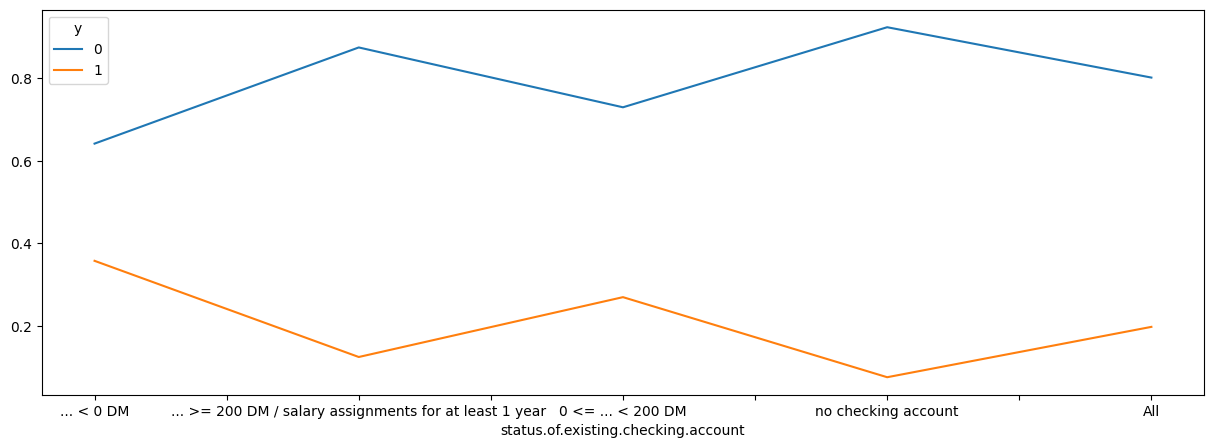

In [15]:
#Representación gráfica de la tabla de contingencia
pd.crosstab(dt['status.of.existing.checking.account'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))



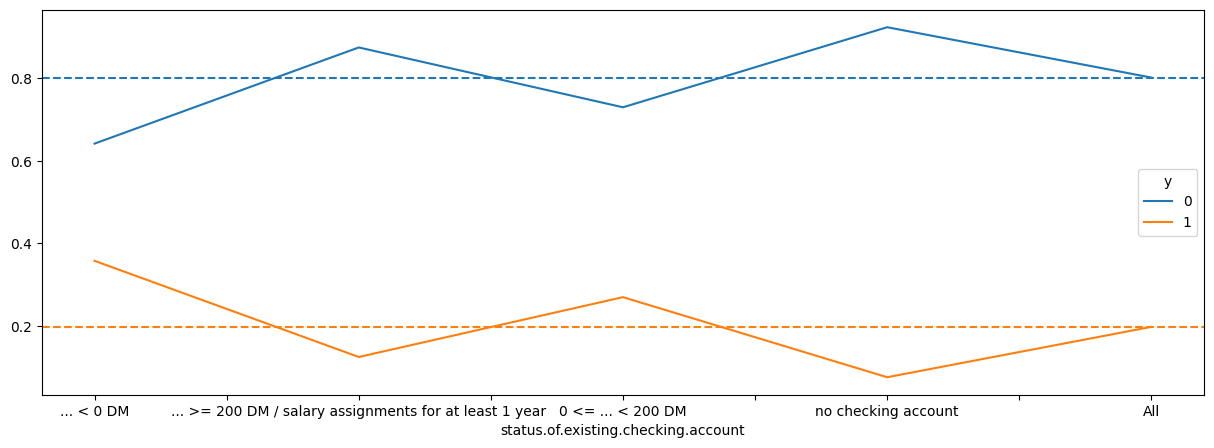

In [16]:
# Para comparar respecto a los totales

pd.crosstab(dt['status.of.existing.checking.account'], dt['y'], margins=True, normalize=0).round(3).plot(figsize=(15, 5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Personal status and sex**

In [17]:
dt['personal.status.and.sex'].value_counts(normalize=True,dropna=False).round(3).sort_index()

personal.status.and.sex
female : divorced/separated/married    0.323
male : divorced/separated              0.052
male : married/widowed                 0.088
male : single                          0.537
Name: proportion, dtype: float64

In [18]:
ctabla=pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
personal.status.and.sex,,,
female : divorced/separated/married,199,55,254
male : divorced/separated,34,7,41
male : married/widowed,57,12,69
male : single,340,82,422
All,630,156,786


In [19]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.9980733377157991


In [20]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
personal.status.and.sex,,
female : divorced/separated/married,0.783,0.217
male : divorced/separated,0.829,0.171
male : married/widowed,0.826,0.174
male : single,0.806,0.194
All,0.802,0.198


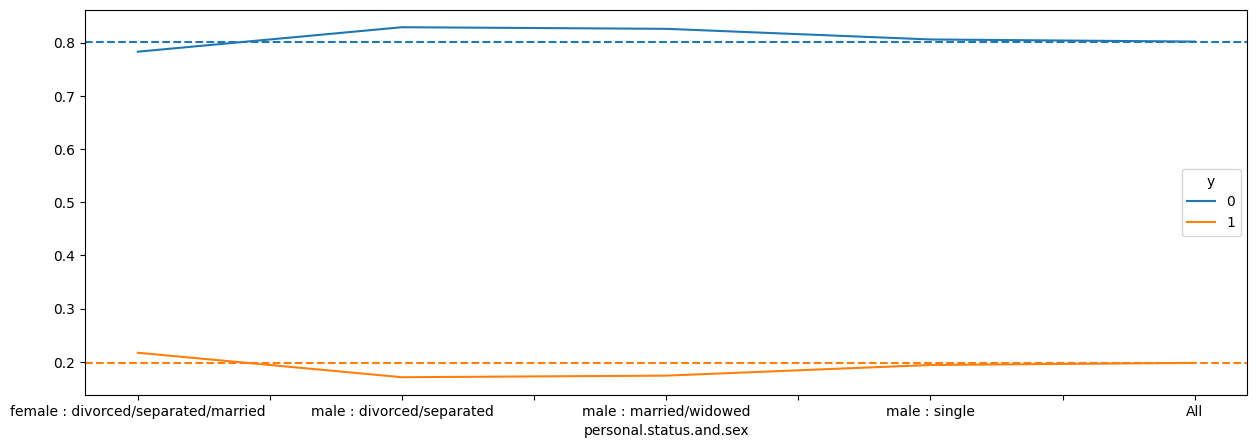

In [21]:
pd.crosstab(dt['personal.status.and.sex'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Housing**

In [22]:
dt['housing'].value_counts(normalize=True,dropna=False).sort_index()

housing
for free    0.097964
own         0.725191
rent        0.176845
Name: proportion, dtype: float64

In [23]:
ctabla=pd.crosstab(dt['housing'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
housing,,,
for free,56,21,77
own,475,95,570
rent,99,40,139
All,630,156,786


In [24]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.03907495849121827


In [25]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
housing,,
for free,0.727,0.273
own,0.833,0.167
rent,0.712,0.288
All,0.802,0.198


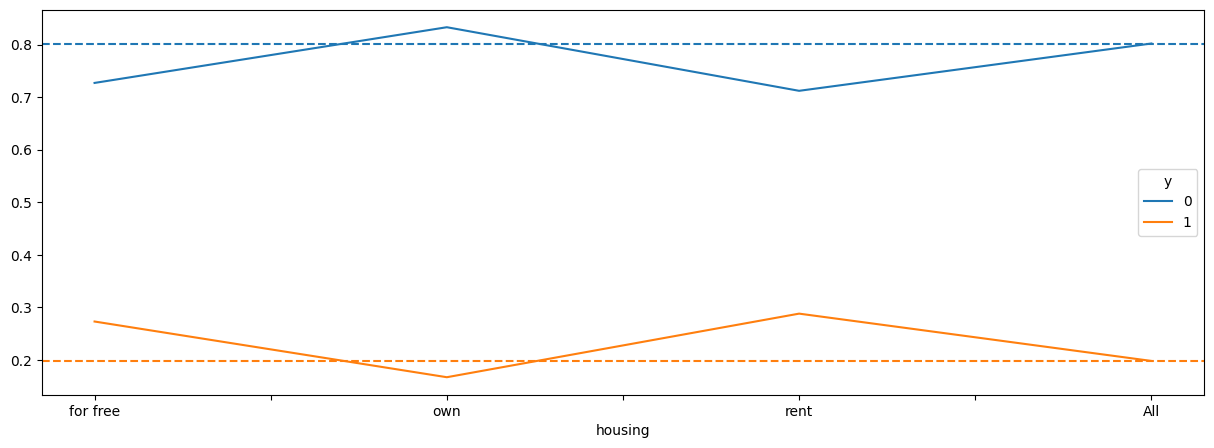

In [26]:
pd.crosstab(dt['housing'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

### **Job**

In [27]:
dt['job'].value_counts(normalize=True,dropna=False).sort_index()

job
management/ self-employed/ highly qualified employee/ officer    0.147583
skilled employee / official                                      0.619593
unemployed/ unskilled - non-resident                             0.020356
unskilled - resident                                             0.212468
Name: proportion, dtype: float64

In [28]:
ctabla=pd.crosstab(dt['job'],dt['y'],margins=True).round(3)
ctabla

y,0,1,All
job,,,
management/ self-employed/ highly qualified employee/ officer,84,32,116
skilled employee / official,399,88,487
unemployed/ unskilled - non-resident,11,5,16
unskilled - resident,136,31,167
All,630,156,786


In [29]:
# Chi-square test of independence. 
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print(p)

0.5566898913002554


In [30]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3)

y,0,1
job,,
management/ self-employed/ highly qualified employee/ officer,0.724,0.276
skilled employee / official,0.819,0.181
unemployed/ unskilled - non-resident,0.688,0.312
unskilled - resident,0.814,0.186
All,0.802,0.198


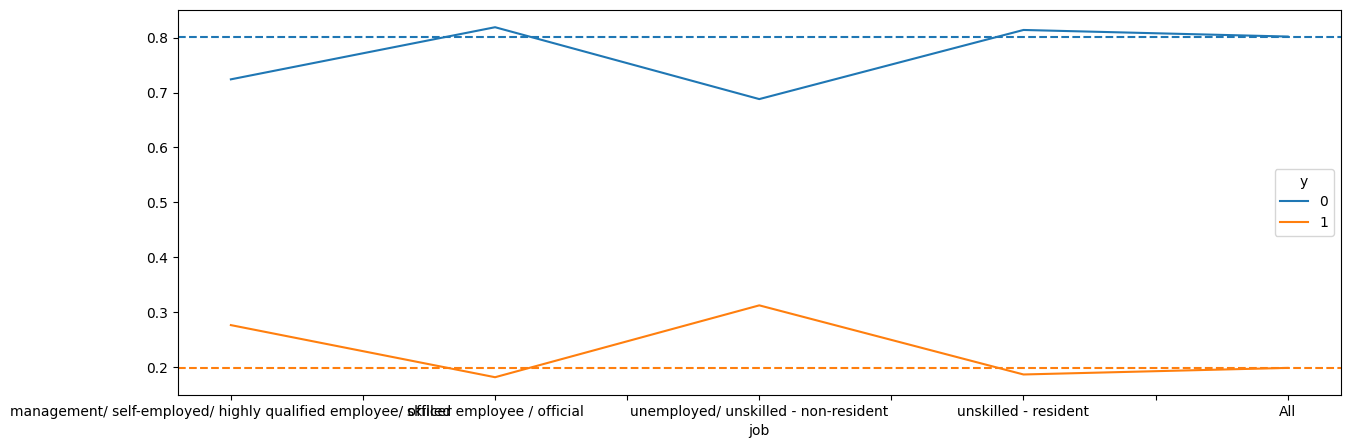

In [31]:
pd.crosstab(dt['job'],dt['y'],margins=True, normalize=0).round(3).plot(figsize=(15,5))
plt.axhline(y=yT_0, color='#1f77b4', linestyle='--')
plt.axhline(y=yT_1, color='#ff7f0e', linestyle='--')
plt.show()

 ....  Habría que seguir haciendo esto con todas las variables categóricas para analizar asociación

## Analisis univariante y de asociación con la variable objetivo de las **Variables continuas**

In [32]:
dt.describe()

,duration.in.month,credit.amount,installment.rate.in.percentage.of.disposable.income,present.residence.since,age.in.years,number.of.existing.credits.at.this.bank,number.of.people.being.liable.to.provide.maintenance.for,y
count,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000,786.000000
mean,20.349873,3220.309160,2.980916,2.877863,35.866412,1.396947,1.160305,0.198473
std,11.799967,2800.893778,1.129068,1.107171,11.522837,0.571235,0.367123,0.399104
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000,0.000000
25%,12.000000,1383.000000,2.000000,2.000000,27.000000,1.000000,1.000000,0.000000
50%,18.000000,2301.500000,3.000000,3.000000,34.000000,1.000000,1.000000,0.000000
75%,24.000000,3855.250000,4.000000,4.000000,42.000000,2.000000,1.000000,0.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000,1.000000


### **Credit.amount**

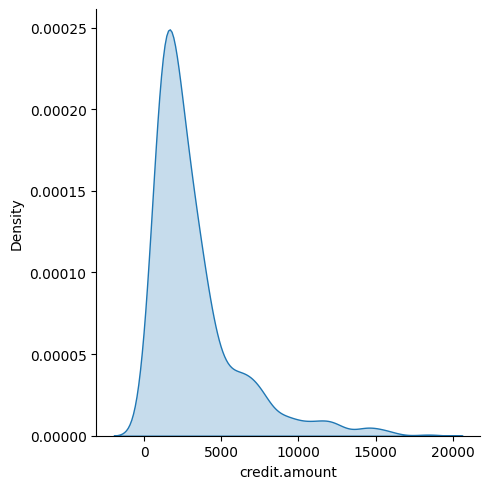

In [33]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True)
plt.show()

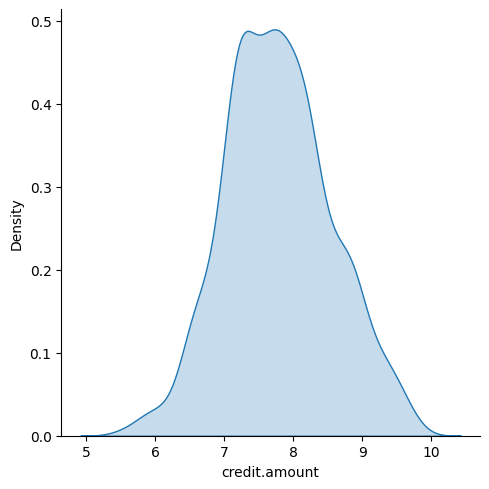

In [34]:
sns.displot(x=np.log(dt['credit.amount']), kind="kde", fill=True)
plt.show()

In [35]:
dt['credit.amount']=np.log(dt['credit.amount'])

Recordad que tenéis que hacer la misma transformación también en el conjunto de Rechazados y de Nuevos

In [36]:
Rechazados['credit.amount']=np.log(Rechazados['credit.amount'])
Nuevos['credit.amount']=np.log(Nuevos['credit.amount'])

Veamos si se aprecian diferencias en la variable principal solicitado y el riesgo de impago

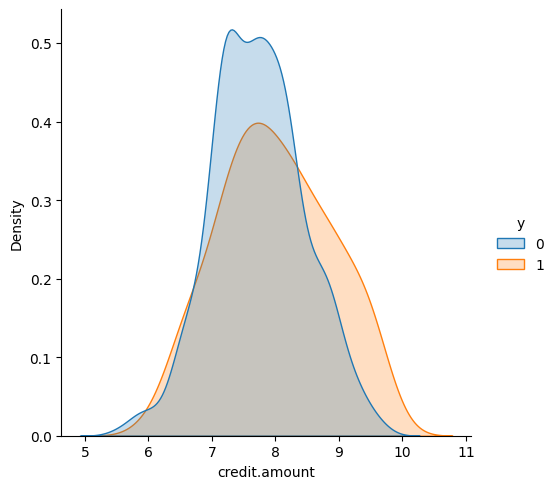

In [37]:
sns.displot(x=(dt['credit.amount']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

In [38]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['credit.amount']], dt.loc[dt["y"]==1,['credit.amount']])
print(fvalue, pvalue)


[16.54141934] [5.24090288e-05]


### **duration.in.month**

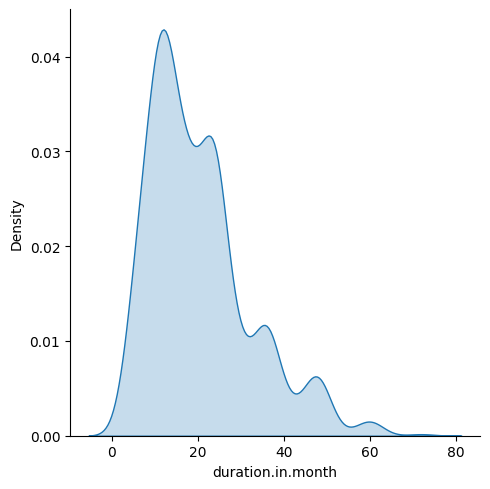

In [39]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True)
plt.show()

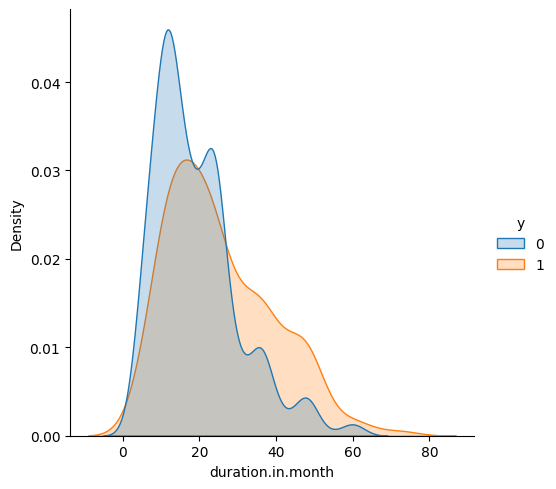

In [40]:
sns.displot(x=(dt['duration.in.month']), kind="kde", fill=True, hue=dt.y, common_norm=False)
plt.show()

In [41]:
fvalue, pvalue = f_oneway(dt.loc[dt["y"]==0,['duration.in.month']], dt.loc[dt["y"]==1,['duration.in.month']])
print(fvalue, pvalue)

[37.35711155] [1.54937726e-09]


Tendría que continuar con el análisis del resto de variables continuas .....

## **Selección de Variables**: análisis de Concentración para seleccionar las variables más **importantes** para meter en el modelo de Aceptados

### Dividimos la muestra en entrenamiento y test

In [42]:
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=321)

In [43]:
dt_train["y"].shape

(589,)

In [44]:
dt_train["y"].mean()

0.19864176570458403

In [45]:
dt_test["y"].shape

(197,)

In [46]:
dt_test["y"].mean()

0.19796954314720813

## Defino la tramificación óptima

## Tramificación de la Variable: "credit.amount"

In [47]:
variable="credit.amount"
X=dt_train[variable].values
Y=dt_train['y'].values

In [48]:
optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

# Si se quisiese fijar los intervalos manualmente (porque no gusten los que obtine el agoritmo, entonces habría que usar:
#                     user_splits=
#                     user_splits_fixed=
# HAy veces que los datos tienen dátos missing y códigos especiales en este caso para obtener una categoría con esos datos missing y datos especiales hay que establecerlos
#                     special_codes = [-9, -8, -7]

# Una vez definido podemos pasar a estimarlo
optb.fit(X, Y)
optb.splits

array([6.80737853, 7.16780806, 7.68248248, 7.78322077, 8.31320143,
       8.95680189])

Nota: Por defecto se utiliza un arbol de clasificación para hacer una tramificación inicial, y después se aplica un proceso de optimización de agrupación de categorías para maximizar el Valor de Información 

Una vez realizado el proceso de tramificación y agrupación óptima de categorías, obtenemos la tabla de agrupación 

In [49]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.81)",56,0.095076,44,12,0.214286,-0.095522,0.000893,0.000112
1,"[6.81, 7.17)",78,0.132428,66,12,0.153846,0.309943,0.011550,0.001438
2,"[7.17, 7.68)",136,0.230900,116,20,0.147059,0.363053,0.027165,0.003377
3,"[7.68, 7.78)",36,0.061121,34,2,0.055556,1.438408,0.079026,0.009106
4,"[7.78, 8.31)",144,0.244482,118,26,0.180556,0.117783,0.003272,0.000409
5,"[8.31, 8.96)",99,0.168081,74,25,0.252525,-0.309616,0.017616,0.002193
6,"[8.96, inf)",40,0.067912,20,20,0.500000,-1.394805,0.179326,0.020759
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,589,1.000000,472,117,0.198642,,0.318847,0.037394


Cabe mencionar que el WOE en esta tabla parece estar definido al revés que lo hemos hecho en clase, por lo que el signo es justo el contrario al que cabría esperar según lo que hemos visto en clase. En particular por defecto `optbinning` define el WOE de una categoría $i$ como
$$ WOE_i =  ln \left ( {Non-event_i \over Non-event_{total}} \over {Event_i \over Event_{total}}    \right ) $$

En este sentido los niveles con mayor tasa de impagados tendrán un WOE menos, y a medida que se reduzca la tasa de impagados (mejor calidad crediticia) irá aumentando el WOE. De hecho, 'optbinning' ni siquiera utiliza la misma fórmula que yo he utilizado en clase, por lo que no está acotada entre cero y uno, puede valos más que uno sin que eso signifique sobre ajuste.

Por talmotivo utilizaremos como criterio de selección exclusivamente IV<0.002

Podemos extraer el IV y el índice de Gini a partir de la tabla

In [50]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))

# La última columna muestra el estadístico Jensen-Shannon de divergencia.
# Es una medida de la similaridad entre dos distribuciones de probabilidad (frecuencias de buenos y malos )
# que está acotada entre 0 y log2 (aprox 0.70) (puede utilizarse 0.01 como mínimo) 
print("JS= ", binning_table.js.round(3))



IV=  0.319
Gini=  0.271
JS=  0.037


In [51]:
# Podemos profundizar en el análisis estimando otras medidas
binning_table.analysis(pvalue_test="chi2")
 

---------------------------------------------
OptimalBinning: Binary Binning Table Analysis
---------------------------------------------

  General metrics

    Gini index               0.27143995
    IV (Jeffrey)             0.31884733
    JS (Jensen-Shannon)      0.03739353
    Hellinger                0.03856793
    Triangular               0.14133801
    KS                       0.18546284
    HHI                      0.17626203
    HHI (normalized)         0.07329478
    Cramer's V               0.23632433
    Quality score            0.03938796

  Monotonic trend                valley

  Significance tests

    Bin A  Bin B  t-statistic  p-value  P[A > B]  P[B > A]
        0      1     0.809890 0.368153  0.814296  0.185704
        1      2     0.017957 0.893401  0.543866  0.456134
        2      3     2.136629 0.143818  0.959006  0.040994
        3      4     3.425752 0.064187  0.014173  0.985827
        4      5     1.832449 0.175839  0.089230  0.910770
        5      6     7.9

In [52]:
# Por ejemplo otra medida que suele utilizarse en el Quality score(QS) que
# está acotada entre 0 y 1 (puede utilizarse 0.01 como mínimo)

print("QS= ", binning_table.quality_score.round(3))

QS=  0.039


In [53]:
# La tabla anterior también muestra la V de Cramer (por encima de 0.20 podría ser suficiente para
# decir que hay asociación, pero también podemos realizar el test con la tabla de contigencia completa:Jensen-Sha
x_transform_indices = optb.transform(X, metric="indices")

#pd.Series(x_transform_indices).value_counts(normalize=True,dropna=False).sort_index()
ctabla=pd.crosstab(pd.Series(x_transform_indices),Y,margins=True).round(3)
print(ctabla)

# Chi-square test of independence. Ho: Ausencia de Asociación (independencia)
c, p, dof, expected = chi2_contingency(ctabla) 
# Print the p-value
print("Test independencia. Estadístico :" ,round(c,3), "p-valor:", round(p,3))

col_0    0    1  All
row_0               
0       44   12   56
1       66   12   78
2      116   20  136
3       34    2   36
4      118   26  144
5       74   25   99
6       20   20   40
All    472  117  589
Test independencia. Estadístico : 32.895 p-valor: 0.003


Podemos realizar una representación gráfica de la Tabla de tramificación

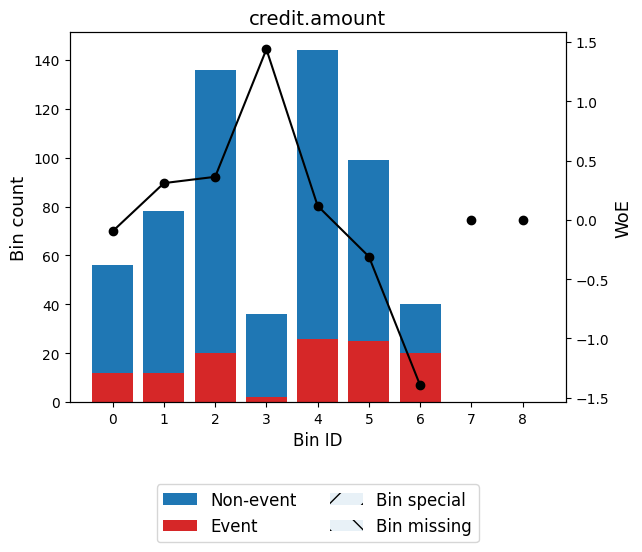

In [54]:
binning_table.plot(metric="woe")

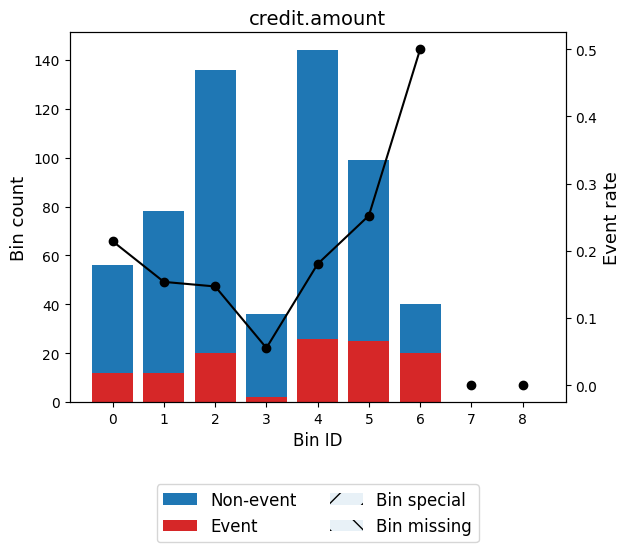

In [55]:
binning_table.plot(metric="event_rate")

Nótese que la relación entre lavariable x (credit.amount) y la tasa de evento (impago) es **no-lineal**

Ahora podemos aplicar esta tramificación óptima a la variable original y obtener la variable transformada WOE (que será una variable continua que utilizaremos en el modelode regresión)

In [56]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index()

-1.394805     40
-0.309616     99
-0.095522     56
 0.117783    144
 0.309943     78
 0.363053    136
 1.438408     36
Name: count, dtype: int64

Fíjate que ahora hemos conseguido "linealizar" la relación entre la variable trasnformada Woe y la propensión al impago 

In [57]:
pd.crosstab(x_woe,Y,normalize=0).round(3)

col_0,0,1
row_0,,
-1.394805,0.500,0.500
-0.309616,0.747,0.253
-0.095522,0.786,0.214
0.117783,0.819,0.181
0.309943,0.846,0.154
0.363053,0.853,0.147
1.438408,0.944,0.056


Text(0, 0.5, 'porcentaje de impago')

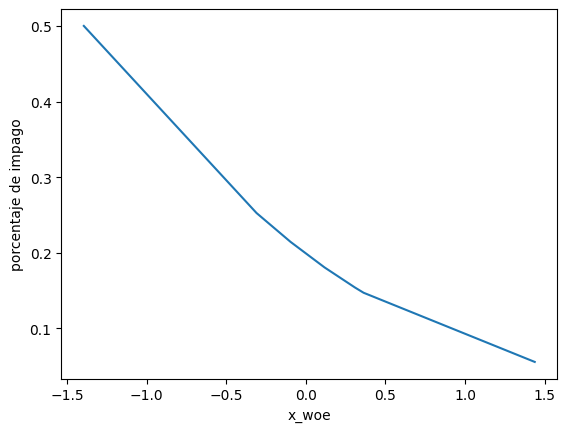

In [58]:
fig, ax = plt.subplots()
ax.plot(pd.crosstab(x_woe,Y,normalize=0).iloc[:,1])
ax.set_xlabel("x_woe")
ax.set_ylabel("porcentaje de impago")

Nótese que para hacer la validación deberíamos hacer exactamente la misma transformación WOE, con la misma tramificación, al conjunto test. Para ello debemos aplicar la transformación optima calculada con el conjunto de entrenamiento, pero sobre la muestra de validación 

In [59]:
# Transformación WOE en el conjunto test
x_test_woe = optb.transform(dt_test[variable].values, metric="woe")
pd.Series(x_test_woe).value_counts().sort_index()

-1.394805    15
-0.309616    25
-0.095522    17
 0.117783    48
 0.309943    18
 0.363053    63
 1.438408    11
Name: count, dtype: int64

Nótese que **no** estamos calculando una nueva tramificación para el conjunto de test, sino aplicando la tramificación obtenida con el conjunto de entrenamiento.    
En realidad si hiciéramos una tramificación óptima con el conjunto de test no tendría porqué salir igual que la estimada para el conunto de entrenamiento, como se puede comprobar a continuación

In [60]:
variable="credit.amount"
X_test=dt_test[variable].values
Y_test=dt_test['y'].values
optb_test = OptimalBinning(name=variable, dtype="numerical")
optb_test.fit(X_test, Y_test)
print(optb_test.splits)
binning_table_test = optb_test.binning_table
binning_table_test.build()

[6.68835378 7.20340514 7.33465552 8.01499557 9.18095398]


,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.69)",16,0.081218,11,5,0.312500,-0.610576,0.035771,0.004403
1,"[6.69, 7.20)",24,0.121827,23,1,0.041667,1.736461,0.208251,0.023186
2,"[7.20, 7.33)",21,0.106599,18,3,0.142857,0.392726,0.014531,0.001805
3,"[7.33, 8.01)",69,0.350254,56,13,0.188406,0.061369,0.001295,0.000162
4,"[8.01, 9.18)",57,0.289340,46,11,0.192982,0.031713,0.000288,0.000036
5,"[9.18, inf)",10,0.050761,4,6,0.600000,-1.804498,0.231932,0.025604
6,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
7,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,197,1.000000,158,39,0.197970,,0.492068,0.055196


Nótese que con el conjunto de test se han obtenido sólo 6 tramos y con diferentes puntos de corte ( y diferentes WOE), por eso es necesario no hacer una nueva tramificación al conjnto de test sino aplicar la tramificación obtenida usando en el conjunto de entrenamiento

## Tramificación de la duración en meses

In [61]:
variable="duration.in.month"
X=dt_train[variable].values
Y=dt_train['y'].values

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")

optb.fit(X, Y)
optb.splits

array([ 8.5, 11.5, 16.5, 26.5, 31.5, 40.5])

In [62]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 8.50)",56,0.095076,51,5,0.089286,0.927583,0.060586,0.007313
1,"[8.50, 11.50)",54,0.091681,48,6,0.111111,0.684636,0.034514,0.004232
2,"[11.50, 16.50)",162,0.275042,135,27,0.166667,0.214633,0.011858,0.001479
3,"[16.50, 26.50)",188,0.319185,150,38,0.202128,-0.021756,0.000152,0.000019
4,"[26.50, 31.50)",33,0.056027,26,7,0.212121,-0.082619,0.000392,0.000049
5,"[31.50, 40.50)",53,0.089983,37,16,0.301887,-0.556476,0.032477,0.004008
6,"[40.50, inf)",43,0.073005,25,18,0.418605,-1.066301,0.107568,0.012843
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,589,1.000000,472,117,0.198642,,0.247548,0.029944


In [63]:
print("IV= ", binning_table.iv.round(3))
print("Gini= ", binning_table.gini.round(3))


IV=  0.248
Gini=  0.257


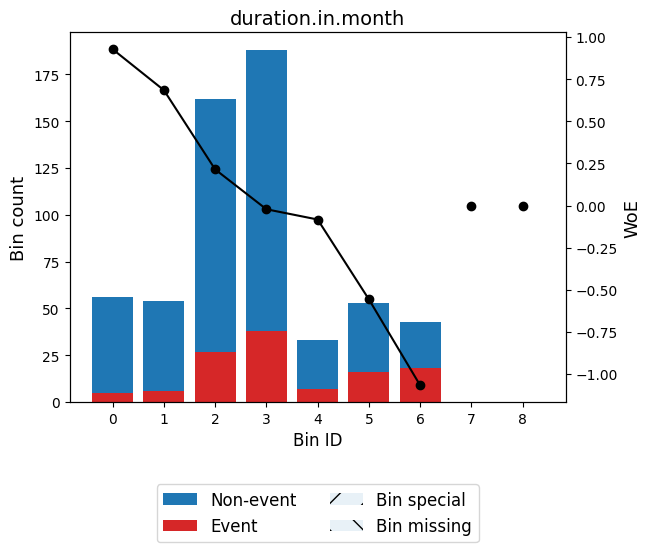

In [64]:
binning_table.plot(metric="woe")

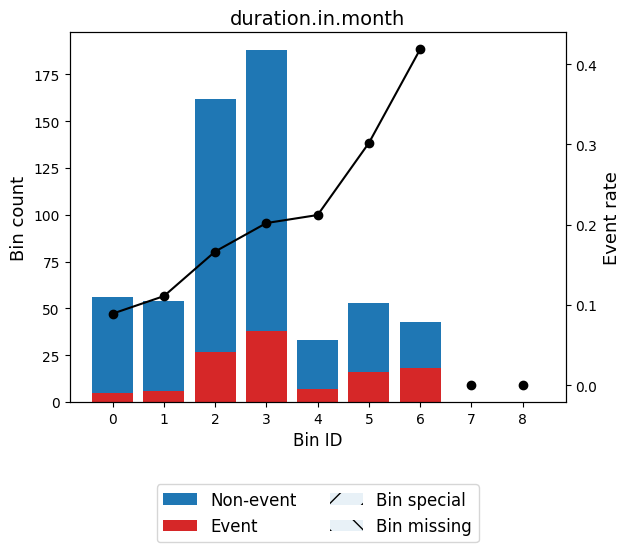

In [65]:
binning_table.plot(metric="event_rate")

In [66]:
# Transformación WOE
x_woe = optb.transform(X, metric="woe")
pd.Series(x_woe).value_counts().sort_index

<bound method Series.sort_index of -0.021756    188
 0.214633    162
 0.927583     56
 0.684636     54
-0.556476     53
-1.066301     43
-0.082619     33
Name: count, dtype: int64>

## Agrupción de niveles en variables Vbles Categóricas

En realidad, cuando tenemosvariables categóricas, no es necesario tramificar, pero sí hacer una agrupación de los diferentes niveles de forma que se maximice el *valor de información*

## Agrupación de la variable  *purpose*

In [67]:
variable_cat = "purpose"
X_cat = dt_train[variable_cat].values
Y_cat = dt_train['y'].values

dt_train[variable_cat].value_counts()

purpose
radio/television       168
car (new)              134
furniture/equipment    104
car (used)              60
business                56
education               29
repairs                 12
domestic appliances      9
others                   9
retraining               8
Name: count, dtype: int64

In [68]:

optb = OptimalBinning(name=variable_cat, dtype="categorical", solver="cp",
                      cat_cutoff=0.1)  # podemos cambiar los valores por defecto cat_cutoff=None, o, cat_cutoff=0.005

optb.fit(X_cat, Y_cat)
optb.splits

[array(['car (used)'], dtype=object),
 array(['radio/television'], dtype=object),
 array(['furniture/equipment'], dtype=object),
 array(['car (new)'], dtype=object),
 array(['business', 'education', 'repairs', 'domestic appliances',
        'others', 'retraining'], dtype=object)]

In [69]:
binning_table = optb.binning_table
binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[car (used)],60,0.101868,52,8,0.133333,0.476997,0.019935,0.002469
1,[radio/television],168,0.285229,145,23,0.136905,0.446434,0.049386,0.006122
2,[furniture/equipment],104,0.176570,83,21,0.201923,-0.020487,0.000075,0.000009
3,[car (new)],134,0.227504,100,34,0.253731,-0.315995,0.024880,0.003097
4,"[business, education, repairs, domestic applia...",123,0.208829,92,31,0.252033,-0.307004,0.021503,0.002677
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,589,1.000000,472,117,0.198642,,0.115778,0.014375


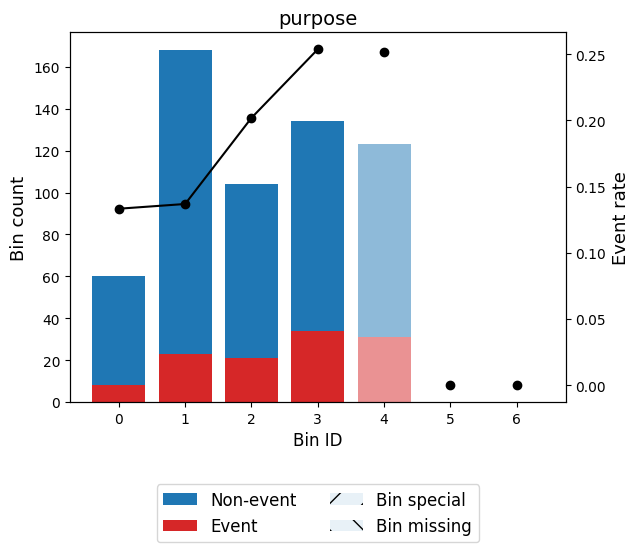

In [70]:
binning_table.plot(metric="event_rate")

In [71]:
x_woe = optb.transform(X_cat, metric="woe")
pd.Series(x_woe).value_counts()


 0.446434    168
-0.315995    134
-0.307004    123
-0.020487    104
 0.476997     60
Name: count, dtype: int64

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

__________________________________________________________________________________________________________________________________________________________________________________________________
__________________________________________________________________________________________________________________________________________________________________________________________________

## Proceso de tramificación, agrupación y trasformación WOE Completo

Para no ir variable a variable se puede hacer todo el proceso completo

Proceso Entero



In [72]:
# 1) Definimos la lista de nombres señalando cualse de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la primera que es el ID y la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

In [73]:
# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02}  # no imponemos "max": 1}
}

In [74]:
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

In [75]:
# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

In [76]:
# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)

In [77]:
dt_train_binned.summary().sort_values('iv')

,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.000193,0.000024,0.005052,0.000031
18,telephone,categorical,OPTIMAL,False,2,0.001307,0.000163,0.017782,0.000963
10,present.residence.since,numerical,OPTIMAL,False,3,0.006702,0.000837,0.028756,0.006088
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,False,2,0.007597,0.000949,0.041667,0.011709
8,personal.status.and.sex,categorical,OPTIMAL,False,4,0.01946,0.00243,0.072939,0.000278
16,job,categorical,OPTIMAL,True,3,0.020758,0.002587,0.064048,0.008472
13,other.installment.plans,categorical,OPTIMAL,True,2,0.031305,0.003898,0.072016,0.049356
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,4,0.035288,0.004386,0.087299,0.027392
9,other.debtors.or.guarantors,categorical,OPTIMAL,True,2,0.054397,0.006406,0.042228,0.027118


In [78]:
# Ahora podemos ir sacando las tablas para cada variable

dt_train_binned.get_binned_variable("credit.amount").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,"(-inf, 6.81)",56,0.095076,44,12,0.214286,-0.095522,0.000893,0.000112
1,"[6.81, 7.17)",78,0.132428,66,12,0.153846,0.309943,0.011550,0.001438
2,"[7.17, 7.68)",136,0.230900,116,20,0.147059,0.363053,0.027165,0.003377
3,"[7.68, 7.78)",36,0.061121,34,2,0.055556,1.438408,0.079026,0.009106
4,"[7.78, 8.31)",144,0.244482,118,26,0.180556,0.117783,0.003272,0.000409
5,"[8.31, 8.96)",99,0.168081,74,25,0.252525,-0.309616,0.017616,0.002193
6,"[8.96, inf)",40,0.067912,20,20,0.500000,-1.394805,0.179326,0.020759
7,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
8,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,589,1.000000,472,117,0.198642,,0.318847,0.037394


In [79]:
dt_train_binned.get_binned_variable("purpose").binning_table.build()

,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS
0,[car (used)],60,0.101868,52,8,0.133333,0.476997,0.019935,0.002469
1,[radio/television],168,0.285229,145,23,0.136905,0.446434,0.049386,0.006122
2,[furniture/equipment],104,0.176570,83,21,0.201923,-0.020487,0.000075,0.000009
3,[car (new)],134,0.227504,100,34,0.253731,-0.315995,0.024880,0.003097
4,"[business, education, repairs, domestic applia...",123,0.208829,92,31,0.252033,-0.307004,0.021503,0.002677
5,Special,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
6,Missing,0,0.000000,0,0,0.000000,0.0,0.000000,0.000000
Totals,,589,1.000000,472,117,0.198642,,0.115778,0.014375


In [80]:
dt_train_binned.information()

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Statistics
    Number of records                    589
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    14

  Time                                0.9314 sec



In [81]:
# las variables seleccionadas se pueden obtener con 'get_support'"Tarea Estudiantes_TarjetaPuntuacion"
dt_train_binned.get_support()

array([ True,  True,  True,  True,  True,  True,  True,  True, False,
        True, False,  True,  True,  True,  True, False,  True, False,
       False, False])

In [82]:
# Podemos transformar las variables WOE
dt_train_woe=dt_train_binned.transform(X, metric="woe")

# Existe la posibilidad de obtener directamente las transformada si en lugar de usar fit, hubiésemos usado fit_transform 
# dt_train_binned = binning_process.fit_transform(X, Y)
# dt_train_binned.info()
# el resultado sería un data.frame con las X seleccionadas trasnsformadas WOE



In [83]:
dt_train_woe.info()

<class 'pandas.core.frame.DataFrame'>
Index: 589 entries, 514 to 724
Data columns (total 14 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  589 non-null    float64
 1   duration.in.month                                    589 non-null    float64
 2   credit.history                                       589 non-null    float64
 3   purpose                                              589 non-null    float64
 4   credit.amount                                        589 non-null    float64
 5   savings.account.and.bonds                            589 non-null    float64
 6   present.employment.since                             589 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  589 non-null    float64
 8   other.debtors.or.guarantors                          589 non-null    floa

In [84]:
dt_train_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing,job
514,0.933533,0.214633,0.783727,0.446434,0.309943,0.925799,0.373965,-0.121839,-0.043913,-0.050060,0.303864,0.091437,0.198058,0.086131
411,0.933533,0.214633,-0.063861,0.446434,0.363053,-0.466818,0.327962,0.090580,-0.043913,0.437776,0.738704,0.091437,0.198058,0.086131
677,-0.354787,-0.021756,-0.063861,0.476997,0.117783,0.925799,0.373965,-0.121839,-0.043913,-0.609850,0.303864,-0.343260,-0.413976,0.086131
149,-0.733407,-1.066301,0.783727,0.476997,-0.309616,-0.267793,0.373965,-0.121839,-0.043913,-0.609850,0.738704,-0.343260,-0.413976,0.012109
175,-0.733407,-0.082619,-0.063861,-0.020487,0.117783,-0.267793,0.343466,-0.121839,-0.043913,0.437776,-0.674259,0.091437,-0.471641,0.086131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336,0.933533,-0.021756,-0.063861,0.446434,0.309943,-0.267793,0.373965,-0.121839,-0.043913,0.437776,0.303864,0.091437,0.198058,-0.296193
644,-0.733407,0.214633,-0.063861,-0.020487,0.309943,-0.267793,-0.104431,-0.121839,1.244252,0.032311,-0.674259,0.091437,0.198058,0.012109
220,0.933533,0.927583,-0.063861,-0.307004,0.363053,-0.267793,-0.573824,-0.095522,-0.043913,-0.609850,0.738704,0.091437,0.198058,0.086131
649,-0.354787,-0.082619,-0.063861,0.446434,0.117783,0.925799,0.373965,0.090580,-0.043913,-0.050060,-0.917881,0.091437,0.198058,0.086131


In [85]:
# Ahora aplicaríamos la misma transformación pero al conjunto de test (si hubiera que puntuar a nuevos clientes haríamos lo mismo)

Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

dt_test_woe=dt_train_binned.transform(X_test, metric="woe")
dt_test_woe.info()





<class 'pandas.core.frame.DataFrame'>
Index: 197 entries, 371 to 637
Data columns (total 14 columns):
 #   Column                                               Non-Null Count  Dtype  
---  ------                                               --------------  -----  
 0   status.of.existing.checking.account                  197 non-null    float64
 1   duration.in.month                                    197 non-null    float64
 2   credit.history                                       197 non-null    float64
 3   purpose                                              197 non-null    float64
 4   credit.amount                                        197 non-null    float64
 5   savings.account.and.bonds                            197 non-null    float64
 6   present.employment.since                             197 non-null    float64
 7   installment.rate.in.percentage.of.disposable.income  197 non-null    float64
 8   other.debtors.or.guarantors                          197 non-null    floa

In [86]:
dt_test_woe

,status.of.existing.checking.account,duration.in.month,credit.history,purpose,credit.amount,savings.account.and.bonds,present.employment.since,installment.rate.in.percentage.of.disposable.income,other.debtors.or.guarantors,property,age.in.years,other.installment.plans,housing,job
371,0.933533,0.214633,-0.063861,-0.020487,0.363053,-0.267793,0.343466,0.437776,-0.043913,0.437776,0.303864,0.091437,0.198058,0.012109
33,0.933533,0.214633,-0.063861,0.446434,-0.095522,-0.267793,0.373965,-0.121839,-0.043913,-0.050060,0.303864,0.091437,0.198058,0.086131
329,-0.733407,0.927583,0.783727,-0.315995,-0.095522,1.313245,0.343466,0.437776,-0.043913,0.437776,0.303864,0.091437,0.198058,0.012109
635,-0.733407,-0.556476,-0.063861,0.446434,1.438408,-0.267793,-0.104431,-0.121839,-0.043913,-0.050060,0.303864,0.091437,-0.471641,0.086131
198,-0.733407,-0.082619,-1.277022,-0.307004,-0.309616,-0.267793,0.327962,0.090580,-0.043913,0.032311,0.738704,-0.343260,0.198058,0.086131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
424,0.933533,-0.021756,-0.008511,-0.020487,-0.309616,-0.466818,-0.104431,0.090580,-0.043913,0.032311,0.303864,0.091437,0.198058,0.086131
301,-0.733407,-0.021756,0.783727,-0.020487,0.363053,-0.267793,-0.104431,-0.121839,-0.043913,0.437776,-0.917881,0.091437,-0.471641,0.086131
366,0.933533,-0.021756,-0.063861,-0.020487,0.363053,-0.267793,-0.573824,-0.121839,-0.043913,0.032311,0.303864,0.091437,0.198058,0.012109
669,0.291594,0.927583,-0.008511,0.446434,-0.095522,-0.267793,-0.573824,0.090580,-0.043913,0.032311,-0.190832,-0.343260,0.198058,0.086131


## Estimación del Modelo

Ahora podemos calcular la tarjeta de puntuación. En los apuntes de clase definimos tanto los WOE, como los Odd ratio como la probabilidad de `evento` respecto al `no-evento` (malos clientes o impago=1 respecto a los buenos clientes o impago=0):

$$ odd = {{P}\over {(1-P)}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$
 
 Y la fórmula para obtener la puntuación o los score debe ser una relación negativa con los odd ratio: cuanto mayor la probabilidad de impago (en relación a la de no impago), menor puntuación ha de tener: 

 $$ score {= offset - Factor}~·~{ln(odds)}$$

Para pasar de Probabiliddes de impago a Puntuaciones, habrá que establecer tanto el valor de `offset` como el de `Factor`. Esto se hace de manera arbitraria dependiendo de cada institución financiera.

En general, para determinar estos dos valores es necesario establecer la pendiente de la recta y un punto de la misma.

En cuanto a la pendiente, cuanto más plana sea la pendiente, menor variabilidad tendrán los valores de puntuación de crédito que se alcancen, y al revés, cuanto mayor pendiente más diferencias en la puntuación final. Yo voy a utilizar un apendiente (arbitraria) estableciendo de forma arbitraria cada cuantos puntos de score (**pdo_0**) se dobla el odd ratio: $ score - pdo_0 = {offset -Factor}~ ·{ln(2*odds)}$.

 En cuanto al punto de la recta (arbitrario), puede hacerse estableciento (de manera arbitraria) la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* (**odds_0**)
 
 Así habría que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40  (esto es que cada 40 puntos de calidad creditica se dobla el odd-ratio))
* **scorecard_points** =600  (alguien con calidad crediticia muy buena, de sobresaliente, sacaría 600 puntos)
* **odds_0** =1/50  (odd ratio que se considera de sobresaliente)

La librería `optBinning` [librería OptBinning](http://gnpalencia.org/optbinning/), en realidad utiliza el módulo de `credit scoring` de `SAS-miner` como inspiración, y por eso define al revés tanto los WOE como los odd ratio, es decir `no-evento` en relación a `evento` (clientes buenos respecto a los malos, o no-impago respecto a impago, impago=0 respecto a impago=1). 
$$ odd^B = {{(1-P)}\over {P}} ~~ {,~~  siendo} ~~  {P=Prob(impago=1)} $$

Esto implica que la ecuación que transforma las probabilidades de impago en scores utilizando esta *odds<sup>B</sup>* debe tener pendiente positiva (cuanto mejor *odd<sup>B</sup>* mejor calidad crediticia tiene el cliente)

 $$ score= {offset + Factor} ~·~ {ln(odds^B)}$$
 
 Nótese que ahora habrá que establecer de nuevo los puntos de score que doblan el odd ratio (**pdo_0**), y también la puntuación o score considerada como de sobresaliente(**scorecard_points**) y el odd ratio que debería tener ese cliente de *sobresaliente* **odds_0 <sup>*B*</sup>**, con **odds_0 <sup>*B*</sup>** **= 1/odds_0**.

 Así para estimar la puntuación crediticia con `optBinning` hay que establecer tres parámetros para transformar probabilidades de impago a puntuaciones, por ejemplo:   

* **pdo_0** =40
* **scorecard_points** =600 
* **odds_0 <sup>*B*</sup>** = 50  (equivalente a **odds_0** =1/50 )




In [87]:

# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs", penalty="l2")
# estimator = LogisticRegression(solver="liblinear", penalty="l1")
# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['status.of.existing.checking.account',
                                                                'credit.history',
                                                                'purpose',
                                                                'savings.account.and.bonds',
                                                                'present.employment.since',
                                                                'personal.status.and.sex',
                                                                'other.debtors.or.guarantors',
                                                                'property',
                                                                'other.installment.plans',
                                                                'housing',
                                                                'job',
                                                                'teleph...
                                                         'other.debtors.or.guarantors',
                                                         'present.residence.since',
                                                         'property',
                                                         'age.in.years',
                                                         'other.installment.plans',
                                                         'housing',
                                                         'number.of.existing.credits.at.this.bank',
                                                         'job',
                                                         'number.of.people.being.liable.to.provide.maintenance.for',
                                                         'telephone',
                                                         'foreign.worker']),
          estimator=LogisticRegression(), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [88]:
tarjeta.information(print_level=2)

optbinning (Version 0.20.1)
Copyright (c) 2019-2024 Guillermo Navas-Palencia, Apache License 2.0

  Begin options
    binning_process                      yes   * U
    estimator                            yes   * U
    scaling_method                  pdo_odds   * U
    scaling_method_params                yes   * U
    intercept_based                    False   * d
    reverse_scorecard                  False   * d
    rounding                           False   * d
    verbose                            False   * d
  End options

  Statistics
    Number of records                    589
    Number of variables                   20
    Target type                       binary

    Number of numerical                    7
    Number of categorical                 13
    Number of selected                    14

  Timing
    Total time                          0.99 sec
    Binning process                     0.93 sec   ( 93.81%)
    Estimator                           0.00 sec   (  0.44%

In [89]:
# Podemos obtener los parámetros del modelo de regresión logística

tarjeta.table(style="detailed")[["Variable","Coefficient"]].groupby(["Variable", "Coefficient"]).nunique()

,
Variable,Coefficient
age.in.years,-0.806929
credit.amount,-0.792258
credit.history,-0.757672
duration.in.month,-0.619781
housing,-0.293951
installment.rate.in.percentage.of.disposable.income,-0.869201
job,-0.016788
other.debtors.or.guarantors,-0.992144
other.installment.plans,-0.183309


In [90]:
tarjeta.table().head(60)

,Variable,Bin,Points
0,status.of.existing.checking.account,[no checking account],70.121124
1,status.of.existing.checking.account,[... >= 200 DM / salary assignments for at lea...,44.214376
2,status.of.existing.checking.account,[0 <= ... < 200 DM],18.128355
3,status.of.existing.checking.account,[... < 0 DM],2.848384
4,status.of.existing.checking.account,Special,32.446507
5,status.of.existing.checking.account,Missing,32.446507
0,duration.in.month,"(-inf, 8.5000)",65.622606
1,duration.in.month,"[8.5000, 11.5000)",56.933346
2,duration.in.month,"[11.5000, 16.5000)",40.123107
3,duration.in.month,"[16.5000, 26.5000)",31.668381


In [91]:
tarjeta.table(style="detailed").head(16)

,Variable,Bin id,Bin,Count,Count (%),Non-event,Event,Event rate,WoE,IV,JS,Coefficient,Points
0,status.of.existing.checking.account,0,[no checking account],259,0.439728,236,23,0.088803,0.933533,0.283251,0.034174,-0.699334,70.121124
1,status.of.existing.checking.account,1,[... >= 200 DM / salary assignments for at lea...,32,0.054329,27,5,0.156250,0.291594,0.004219,0.000525,-0.699334,44.214376
2,status.of.existing.checking.account,2,[0 <= ... < 200 DM],157,0.266553,116,41,0.261146,-0.354787,0.037134,0.004618,-0.699334,18.128355
3,status.of.existing.checking.account,3,[... < 0 DM],141,0.239389,93,48,0.340426,-0.733407,0.156379,0.019121,-0.699334,2.848384
4,status.of.existing.checking.account,4,Special,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.699334,32.446507
5,status.of.existing.checking.account,5,Missing,0,0.000000,0,0,0.000000,0.000000,0.000000,0.000000,-0.699334,32.446507
0,duration.in.month,0,"(-inf, 8.5000)",56,0.095076,51,5,0.089286,0.927583,0.060586,0.007313,-0.619781,65.622606
1,duration.in.month,1,"[8.5000, 11.5000)",54,0.091681,48,6,0.111111,0.684636,0.034514,0.004232,-0.619781,56.933346
2,duration.in.month,2,"[11.5000, 16.5000)",162,0.275042,135,27,0.166667,0.214633,0.011858,0.001479,-0.619781,40.123107
3,duration.in.month,3,"[16.5000, 26.5000)",188,0.319185,150,38,0.202128,-0.021756,0.000152,0.000019,-0.619781,31.668381


Continuamos con la diagnosis del modelo

In [92]:
# obtenemos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)


0.19867

In [93]:
# para contruir las matrices de confusión necesitamos determinar un
# **punto de corte de la probabilidad**.
# Ese punto de corte es el que me va a ayudar a realizar un pronóstico sobre los clientes:
# los malos clientes serán aquelloe para los que Prob Estimada > Prob_corte.


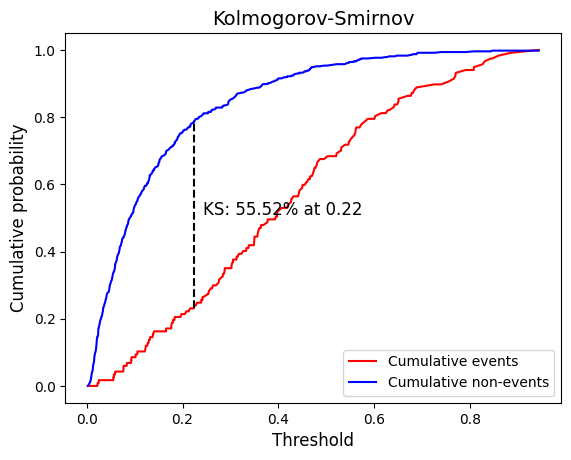

In [94]:
# Para elegir el punto de corte puede utilizarse el Plot Kolmogorov-Smirnov (KS)
plot_ks(Y, Y_pred)

El punto de corte que maximiza el f1_score es:  0.25
y el máximo se alcanza en  0.591


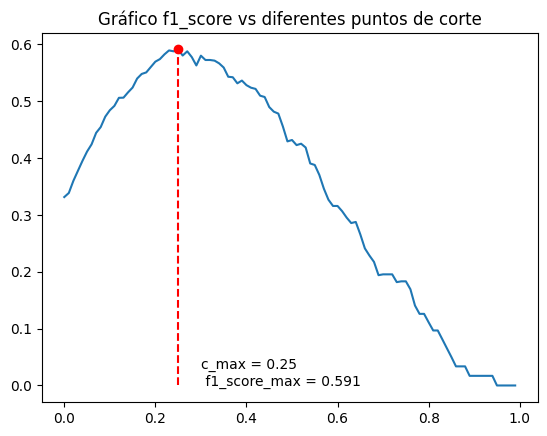

In [95]:
# También puede utilizarse el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["y"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

c_maxF1=c_max

El punto de corte que maximiza el índice de Youden es:  0.23
y el máximo se alcanza en  0.557


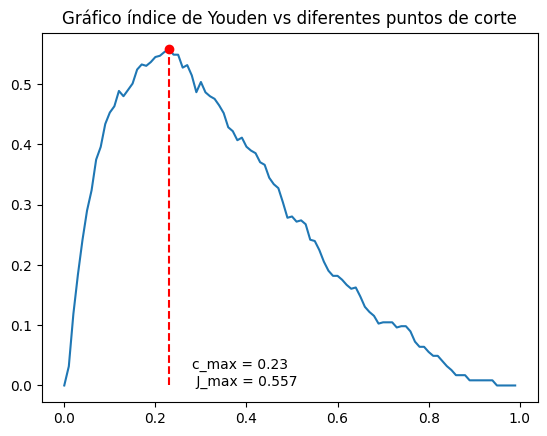

In [96]:
# método de Youden (J) para obtener el punto de corte óptimo
# definimos un vector de puntos de corte (c) y de probabilidad de aceptación (p)
c=np.arange(0,1,0.01)

# Calculamos el estadístico J de Youden para cada punto de corte= Sensibilidad + Especificidad -1
J= [balanced_accuracy_score(dt_train["y"],np.multiply(Y_pred>c_,1), adjusted=True) for c_ in c ]
# obtenemos el punto de corte que maximiza el índice de Youden
c_max = c[np.argmax(J)]
print("El punto de corte que maximiza el índice de Youden es: ", c_max)
print("y el máximo se alcanza en ", np.max(J).round(3))

# gráfico de c y los índices de Youden correspondientes
plt.plot(c,J)
plt.stem(c_max, np.max(J),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico índice de Youden vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n J_max = "+str(np.max(J).round(3)))
plt.show()

In [97]:
# Se podría utilizar simplemente la frecuencia observada, o utilizar el punto donde se alcanza el maximo del F1 Score
Prob_Corte=Y.mean()
#Prob_Corte=c_maxF1
print(' Punto de Corte seleccionado:', Prob_Corte.round(2),'\n',
      'Frecuencia media de eventos (y=1):', Y.mean().round(2), '\n',
      'máximo del F1-score :', c_maxF1)

 Punto de Corte seleccionado: 0.2 
 Frecuencia media de eventos (y=1): 0.2 
 máximo del F1-score : 0.25


In [98]:
dt_train["Y_pronostico"]=np.multiply(Y_pred>Prob_Corte,1)

In [99]:
# Para comprobar la bondad de nuestras predicciones voy a comparar resultados con la tabla de confusión

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
pd.crosstab(dt_train["y"],dt_train["Y_pronostico"],margins=True, normalize=1).round(3)


Y_pronostico,0,1,All
y,,,
0,0.934,0.558,0.801
1,0.066,0.442,0.199


Nótese que los falsos negativos (Bad Rate) es del 6.6% (préstamos aceptados o pronosticados como buenos que resultaron impagados)

In [100]:
# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)

pd.crosstab(dt_train["y"],dt_train["Y_pronostico"],margins=True, normalize=0).round(3)

Y_pronostico,0,1
y,,
0,0.754,0.246
1,0.214,0.786
All,0.647,0.353


In [101]:
# Por último un resumen global de aciertos
f1_score(dt_train["y"],dt_train["Y_pronostico"])

0.5661538461538461

Para hacer la diagnosis también puedo utilizar medidas que no dependan crucialmente de un único punto de corte de Probabilidad

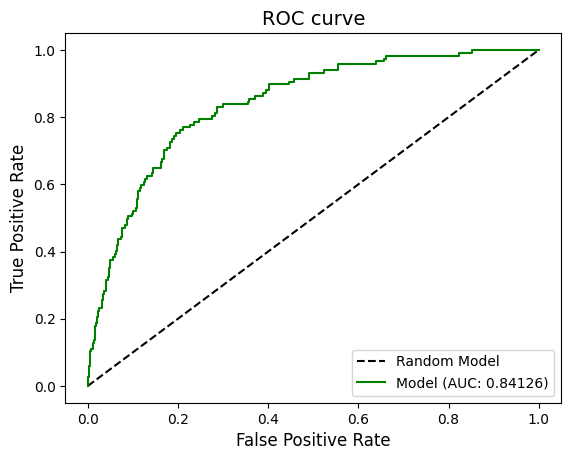

In [102]:
# Diagnosis Curva ROC
plot_auc_roc(Y,Y_pred)

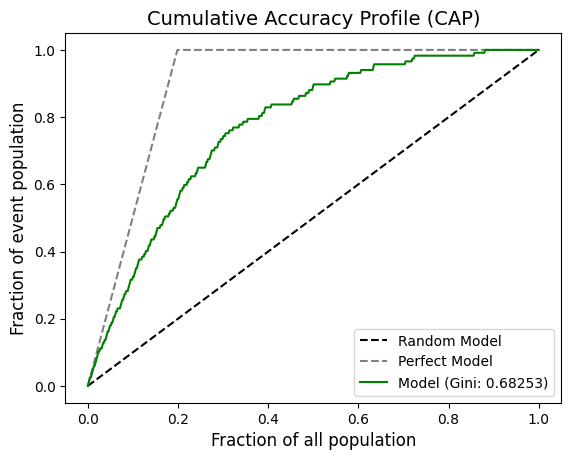

In [103]:
# Diagnosis Cumulative Accuracy Profile (CAP)
# Otra curva alternativa a la curva ROC que permite evaluar la bondad de un modelo de clasificación es la curva CAP (Cumulative Accuracy Profile).
# La curva CAP se construye de la siguiente manera: ordenamos las observaciones de mayor a menor probabilidad
# de pertenecer a la clase positiva (y=1). A continuación, vamos acumulando las observaciones y calculando
# la proporción de positivos acumulados sobre el total de positivos. Esta proporción se representa en el eje Y.

# En el eje X representamos la proporción de observaciones acumuladas sobre el total de observaciones.
# La curva CAP se construye a partir de la curva de la línea recta (curva de referencia) y 
# la curva de la línea que representa la probabilidad estimada por el modelo.

plot_cap(Y, Y_pred)

In [104]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Calculamos la media
Y_test_pred.mean().round(5)

0.19278

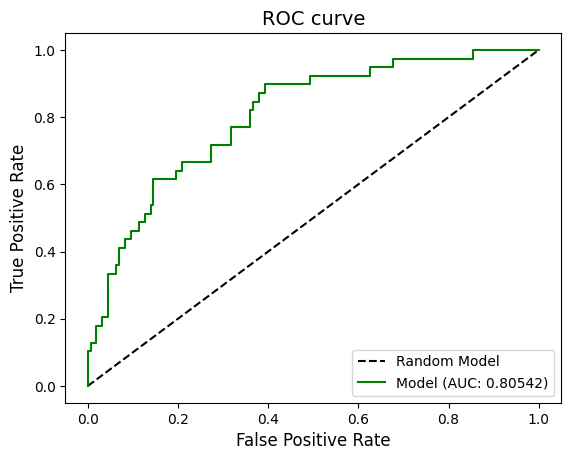

In [105]:
# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


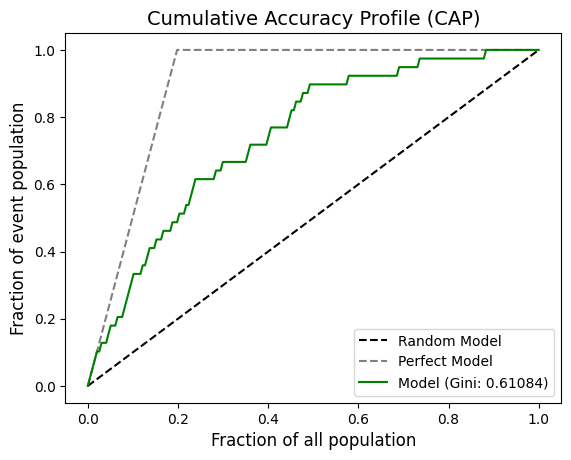

In [106]:
plot_cap(Y_test,Y_test_pred)

In [107]:
dt_test["Y_pronostico"]=np.multiply(Y_test_pred>Prob_Corte,1)

# Primero estimo la precisión (los aciertos sobre el total de mis pronósticos)
print("\n Precisión:\n", pd.crosstab(dt_test["y"],dt_test["Y_pronostico"],margins=True, normalize=1).round(3))

# Ahora estimo la exhaustividad o recall (Aciertos sobre los casos reales):
# la sensibilidad (sobre los positivos y=1), y la Especificidad (sobre los negativos y=0)
print("\n exhaustividad:\n",pd.crosstab(dt_test["y"],dt_test["Y_pronostico"],margins=True, normalize=0).round(3))

# Por último un resumen global de aciertos
print("\n f1-score:",f1_score(dt_test["y"],dt_test["Y_pronostico"]))


 Precisión:
 Y_pronostico      0      1    All
y                                
0             0.901  0.606  0.802
1             0.099  0.394  0.198

 exhaustividad:
 Y_pronostico      0      1
y                         
0             0.747  0.253
1             0.333  0.667
All           0.665  0.335

 f1-score: 0.49523809523809526


In [108]:
# Ahora vamos a calcular los score o puntuaciones.
#Que podemos hacer  con la función score
score = tarjeta.score(X)

print("Puntuación mínima: ", score.min().round(2))
print("Puntuación máxima: ",score.max().round(2))
print("Puntuación media : ",score.mean().round(2))  


# Transformación lineal según apuntes
# Factor= (pdo_0/log(2))
# Offset = scorecard_points_0+(pdo_0/log(2))*log(odds0_0)
# score= Offset - Factor *log(odds)

Factor= (pdo_0/np.log(2))
Offset = scorecard_points_0+Factor*np.log(1/odds_0_B)

#Podríamos haber calculado la puntuación también manualmente
score2= Offset-Factor*np.log(Y_pred/(1-Y_pred))

# Podemos comprobar que los resultados son los mismos   
print('Podemos comprobar que los resultados son los mismos con el cálculo manual')   
print("Puntuación mínima: ",score2.min().round(2))
print("Puntuación máxima: ",score2.max().round(2))
print("Puntuación media : ",score2.mean().round(2))

datos_score=pd.DataFrame(np.transpose([score,score2, Y,Y_pred]), columns=['score','scoreManual','Y','Y_pred'])

# datos_score.to_excel("score_p1.xlsx")


Puntuación mínima:  211.95
Puntuación máxima:  724.84
Puntuación media :  485.65
Podemos comprobar que los resultados son los mismos con el cálculo manual
Puntuación mínima:  211.95
Puntuación máxima:  724.84
Puntuación media :  485.65


Saber cómo se hace la transformación manual puede ayudarnos por ejemplo a la hora de establecer la `nota que determina el aprobado`. Imaginemos que utilizamos la frecuencia observada de impagos como probabilidad de corte 

In [109]:

Score_Corte= Offset-Factor*np.log(Prob_Corte/(1-Prob_Corte))

print("La probabilida de corte de:", Prob_Corte, "equivale a una puntuación de corte de:", Score_Corte.round(2) )


La probabilida de corte de: 0.19864176570458403 equivale a una puntuación de corte de: 454.74


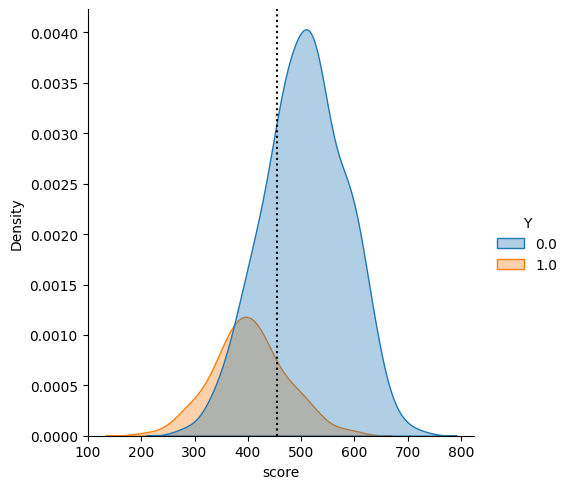

In [110]:
# Ahora representamos en un gráfico cómo separa el modelo a los buenos y los malos
datos_score=pd.DataFrame(np.transpose([score,Y]), columns=['score','Y'])
sns.displot(data=datos_score, x='score', label="event", hue='Y', alpha=0.35,kind="kde", fill=True, common_norm=True)
plt.axvline(Score_Corte, color='k', linestyle=":")

***

# **SEGUNDA ETAPA: Construcción del segundo modelo con los Aceptados y los Rechazados Inferidos**

Como hemos comentado en clase, una de las cuestiones que tenemos que tener en consideración en la construcción de los modelos de puntuación de riesgo es si existe o no algún problema de sesgo de selección muestral (que la muestra utilizada para estimar/entrenar los modelos no sea representativa de toda la población sobre la que se quiera aplicar posteriormente el modelo).
En caso de que sí exista dicho sesgo tendríamos que intentar eliminarlo, y una forma de resolver este problema de sesgo  es mediante la técnica conocida como inferencia de denegados.

Como habréis comprobado ya, en el ejemplo que acabamos de terminar en la anterior etapa hemos estimado un modelo con los datos de los créditos aceptados, y por tanto, como estos clientes eran potencialmente buenos (porque alguien los aceptó como clientes soponiendo que iban a pagar bien, ya que de lo contrario no hubiesen sido aceptados como clientes) es altamente probable que nuestro modelo incorpore un sesgo de selección muestral.

Para eliminar el sesgo de selección muestral por la técnica de la inferncia de denegados hay que incorporar a la muesta de aceptados (solicitantes que alguien consideró que iban a ser buenos clientes) a los clientes rechazados (potenciales malos clientes) de forma que la muestra de entrenamiento del modelo esté conformada por potencialemnte buenos y potencialmente malos solicitantes de un préstamo. De esta forma la muestra de entrenamiento sí que será representatitva de la población sobre la que se va a aplicar el modelo (cualquiera que entre al banco solicitando un préstamo)

El problema es que la variable objetivo (y, la variable impago) sólo se observa para los solicitantes que fueron aceptados. Los solicitantes rechazados, al no concederles el préstamo no podemos saber si hubieran pagado bien o mal.
La técnica de inferencia de denegados consiste precisamente en estimar o inferir qué hubiesen hecho estos clientes rechazados si se les hubiese concedido un préstamo y una vez con todas las variables (la objetivo estimada) ya podría anezarse a los datos de los aceptados para tener la muestra completa de entrenamiento.

Quiero ahora ilustrar cómo se haría la inferencia de Rechazados con la librería `optBinning` cuando sí disponemos de datos para clientes rechazados, como es en nuestro ejemplo. En otros casos simplemente se ha perdido la información de los rechazados y no podemos corregir el sesgo de selección muestral.


Existen varias alternativas, pero yo os propongo dos formas relativamente sencilla de hacerlo.  
A) La más sencilla, pero no la mejor, es asignarle un y=1 a todos los rechazados en la variable impago (es decir, inferir que, ya que fueron rechazados en su día y no se les concedió el crédito, todos hubiesen hecho impago=1).
 
B) Otra alternativa es la conocida como Hard Cut-Off Augmentation, os pongo el esquema general aquí:    
   -  Construimos un primer modelo con la muestra de Aceptados   
   -  Puntuamos a los Rechazados con ese primer modelo, obteniendo una probabilidad de impago para ellos, y en función de esa probabilidad realizamos un pronóstico para su variable impago (para ello es necesario determinar, con la muestra de aceptados, un punto de corte en la probabilidad estimada para inferir el impago=1)    
   -  Se anexa la muestra de Rechazados inferidos y de Aceptados. Esta base ya sí será representativa de todos los posibles clientes que entren por la puerta a solicitar un crédito.    
   -  Con esta muestra se vuelve a estimar el modelo de puntuación, pero empezando desde cero, determinado desde la nueva tramificación hasta el mejor nuevo modelo predictivo    



## Realizamos la inferencia de Rechazados

A partir de ese primer modelo realizamos una predicción de qué es lo que hubiésen hecho los rechazados en caso de que hubiesen sido aceptados en su día, que no lo fueron

In [111]:
# Hacemos la inferencia de rechazados
# Necesitamos puntuar a los rechazados con el modelo estimado sólo con los aceptados
# (Utilizamos el Punto de Corte estimado para el modelo de aceptados)

X_rechazados = Rechazados.drop(columns=['y']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_rechazados_pred=tarjeta.predict_proba(X_rechazados)[:,1]
Rechazados["y"]=np.multiply(Y_rechazados_pred>Prob_Corte,1)

In [112]:
print(Rechazados["y"].value_counts(normalize=True))

y
1    0.585799
0    0.414201
Name: proportion, dtype: float64


Fijáos cómo hemos inferido que un 58% de los rechazados hubieran hecho default

In [113]:
# Hago también una primera estimazión de la puntuación de los nuevos clientes para ver si hay diferencias con y sin rechazados
X_Nuevos = Nuevos.drop(columns=['y']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["Prob_Sinrechazados"]=np.multiply(Y_Nuevos_pred,1)
Nuevos["y_Sinrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)

## Anexamos los datos de los Rechazados inferidos a los Aceptados

In [114]:
dt=pd.concat([dt,Rechazados], axis=0)
dt.info()

<class 'pandas.core.frame.DataFrame'>
Index: 955 entries, 0 to 168
Data columns (total 21 columns):
 #   Column                                                    Non-Null Count  Dtype  
---  ------                                                    --------------  -----  
 0   status.of.existing.checking.account                       955 non-null    object 
 1   duration.in.month                                         955 non-null    int64  
 2   credit.history                                            955 non-null    object 
 3   purpose                                                   955 non-null    object 
 4   credit.amount                                             955 non-null    float64
 5   savings.account.and.bonds                                 955 non-null    object 
 6   present.employment.since                                  955 non-null    object 
 7   installment.rate.in.percentage.of.disposable.income       955 non-null    int64  
 8   personal.status.and.sex  

In [115]:
dt['y'].value_counts()

y
0    700
1    255
Name: count, dtype: int64

In [116]:
dt['y'].value_counts(normalize=True)

y
0    0.732984
1    0.267016
Name: proportion, dtype: float64

fíjate que ha aumentado el porcentaje de impagados, porque hemos incluido a los rechazados, que eran potencialmente malos

## Reestimo el modelo con todos, Aceptados y Rechazados

In [117]:
### Dividimos la muestra en entrenamiento y test
dt_train, dt_test = train_test_split(dt,stratify=dt["y"], test_size=.25, random_state=1234)
print(dt_train["y"].mean(),dt_test["y"].mean())
### Defino la tramificación óptima

# 1) Definimos la lista de nombres señalando cuales de ellas son las categóricas
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y
list_variables = X.columns.values.tolist()
list_categorical = X.select_dtypes(include=['object', 'category']).columns.values.tolist()

# 2) Definimos el criterio de selección
selection_criteria = {
    "iv": {"min": 0.02} #, "max": 1}
}
# En caso de que desee modificarse los valores por defecto en el proceso de tramificación de alguna variable puede hacerse en forma de diccionario

binning_fit_params={
    "purpose":{"cat_cutoff": 0.10}
}

# 3) Definimos el proceso de Tramificación o BinningProcess
binning_process = BinningProcess(
    categorical_variables=list_categorical,
    variable_names=list_variables,
    selection_criteria=selection_criteria,
    binning_fit_params=binning_fit_params)

# 4) Obtenemos los tramos optimos de todas las Variables
dt_train_binned = binning_process.fit(X, Y)
dt_train_binned.summary().sort_values('iv')

0.26675977653631283 0.26778242677824265


,name,dtype,status,selected,n_bins,iv,js,gini,quality_score
19,foreign.worker,categorical,OPTIMAL,False,1,0.0,0.0,0,0.0
18,telephone,categorical,OPTIMAL,False,2,0.000439,0.000055,0.010282,0.00023
17,number.of.people.being.liable.to.provide.maint...,numerical,OPTIMAL,False,2,0.000734,0.000092,0.009454,0.000248
8,personal.status.and.sex,categorical,OPTIMAL,False,3,0.004294,0.000536,0.022199,0.000557
10,present.residence.since,numerical,OPTIMAL,False,3,0.006019,0.000752,0.04006,0.004186
15,number.of.existing.credits.at.this.bank,numerical,OPTIMAL,False,2,0.00693,0.000866,0.039681,0.01191
7,installment.rate.in.percentage.of.disposable.i...,numerical,OPTIMAL,True,3,0.021088,0.002627,0.068173,0.046007
13,other.installment.plans,categorical,OPTIMAL,True,3,0.021743,0.00271,0.060244,0.002742
16,job,categorical,OPTIMAL,True,3,0.022916,0.002854,0.069279,0.0264
9,other.debtors.or.guarantors,categorical,OPTIMAL,True,2,0.080829,0.009308,0.052865,0.04503


In [118]:
# Directamente con el método Scorecard
estimator = LogisticRegression(solver="lbfgs",penalty=None)
# estimator = LogisticRegression(solver="liblinear",penalty="l1")

# Establecemos los parámetros para la transformación de probabilidades en puntos de calidad crediticia o score

pdo_0 =40
scorecard_points_0= 600 
odds_0_B= 50 # (equivalente a  odds_0 =1/50 )

tarjeta= Scorecard(binning_process=binning_process,
                   estimator=estimator,
                   scaling_method="pdo_odds",
                   scaling_method_params={"pdo":pdo_0, "odds": odds_0_B, "scorecard_points": scorecard_points_0})

tarjeta.fit(X, Y, show_digits=4)

Scorecard(binning_process=BinningProcess(binning_fit_params={'purpose': {'cat_cutoff': 0.1}},
                                         categorical_variables=['status.of.existing.checking.account',
                                                                'credit.history',
                                                                'purpose',
                                                                'savings.account.and.bonds',
                                                                'present.employment.since',
                                                                'personal.status.and.sex',
                                                                'other.debtors.or.guarantors',
                                                                'property',
                                                                'other.installment.plans',
                                                                'housing',
                                                                'job',
                                                                'teleph...
                                                         'present.residence.since',
                                                         'property',
                                                         'age.in.years',
                                                         'other.installment.plans',
                                                         'housing',
                                                         'number.of.existing.credits.at.this.bank',
                                                         'job',
                                                         'number.of.people.being.liable.to.provide.maintenance.for',
                                                         'telephone',
                                                         'foreign.worker']),
          estimator=LogisticRegression(penalty=None), scaling_method='pdo_odds',
          scaling_method_params={'odds': 50, 'pdo': 40,
                                 'scorecard_points': 600})

In [119]:
# obtenmos las predicciones
Y_pred=tarjeta.predict_proba(X)[:,1]

# Calculamos la media
Y_pred.mean().round(5)

0.26671

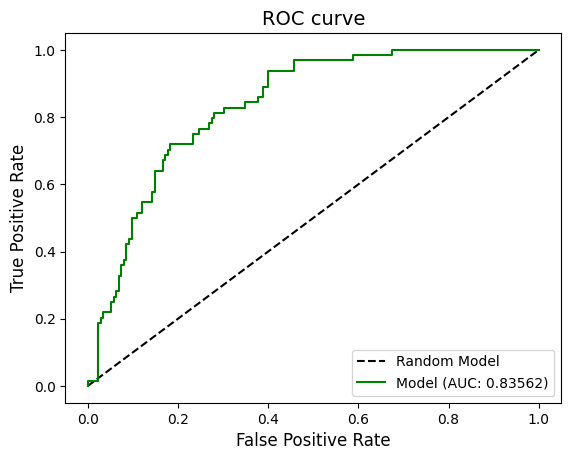

In [120]:
#### OJO que la diagnosis debe hacerse fuera de la muestra de entrenamiento
# obtenmos las predicciones
Y_test = dt_test['y'].values
X_test = dt_test.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

Y_test_pred=tarjeta.predict_proba(X_test)[:,1]

# Diagnosis Curva ROC
plot_auc_roc(Y_test,Y_test_pred)


# **TERCERA ETAPA: Puntuación de las nuevas solicitudes**

El punto de corte que maximiza el f1_score es:  0.33
y el máximo se alcanza en  0.707


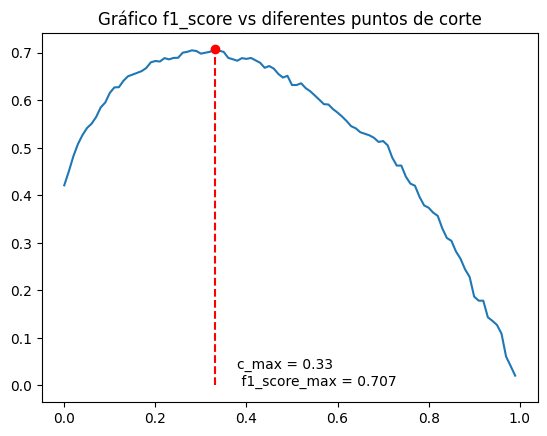

 Punto de Corte seleccionado: 0.26675977653631283 
 Frecuencia media de eventos (y=1): 0.27 
 máximo del F1-score se alcanza para prob: 0.33 
 y el máximo F1-secore es de 0.7


In [121]:
# primero estimo el punto de corte utilizando o bien el valor medio o bien el máximo del f1-score pero
# del segundo modelo (modelo completo con Aceptados y Aceptados)

# Punto de corte el máximo del f1_score
# definimos un vector de puntos de corte
c=np.arange(0,1,0.01)
# calculamos el f1_score para cada punto de corte
f1_score_ = [f1_score(dt_train["y"],np.multiply(Y_pred>c_,1)) for c_ in c]
# obtenemos el punto de corte que maximiza el f1_score
c_max = c[np.argmax(f1_score_)]
print("El punto de corte que maximiza el f1_score es: ", c_max)
print("y el máximo se alcanza en ", np.max(f1_score_).round(3))

# hacemos un gráfico de c y los f1_score correspondientes
plt.plot(c,f1_score_)
plt.stem(c_max, np.max(f1_score_),linefmt='r--', markerfmt='ro', basefmt='r--')
plt.title("Gráfico f1_score vs diferentes puntos de corte")
plt.text(c_max+0.05, 0, "c_max = "+str(c_max.round(2))+"\n f1_score_max = "+str(np.max(f1_score_).round(3)))
plt.show()

c_maxF1=c_max


# Determino el punto de corte óptimo
# Se podría utilizar simplemente la frecuencia observada, pdro voy a utilizar el punto donde se alcanza el maximo del F1 Score
Prob_Corte=Y.mean()
# Prob_Corte=c_maxF1
print(' Punto de Corte seleccionado:', Prob_Corte,'\n',
      'Frecuencia media de eventos (y=1):', round(Y.mean(),2), '\n',
      'máximo del F1-score se alcanza para prob:', c_maxF1, '\n',
      'y el máximo F1-secore es de', f1_score(Y,Y_pred>Prob_Corte).round(3))





In [122]:
# Ahora ya podemos puntuar a los nuevos clientes con el modelo completo

X_Nuevos = Nuevos.drop(columns=['y','Prob_Sinrechazados','y_Sinrechazados']) #todas menos la variable y (que de hecho estaba vacía por que hay que estimarla)
Y_Nuevos_pred=tarjeta.predict_proba(X_Nuevos)[:,1]
Nuevos["Prob_Conrechazados"]=np.multiply(Y_Nuevos_pred,1)
Nuevos["y_Conrechazados"]=np.multiply(Y_Nuevos_pred>Prob_Corte,1)




In [123]:
print("\n Prob estimada de Impago de los Nuevos Solicitantes SIN incluir Rechazados (primer modelo):",Nuevos["Prob_Sinrechazados"].mean().round(3))
print("\n Prob estimada de Impago de los Nuevos Solicitantes CON inferencia de Rechazados (segundo modelo):",Nuevos["Prob_Conrechazados"].mean().round(3))  



 Prob estimada de Impago de los Nuevos Solicitantes SIN incluir Rechazados (primer modelo): 0.219

 Prob estimada de Impago de los Nuevos Solicitantes CON inferencia de Rechazados (segundo modelo): 0.262


Conclusión, si no consideramos a los rechazados a la hora de estimar nuestro modelo estaremos infravalorando la probabilidad de impago de los nuevos solicitantes de un préstamo

***

# Seguimiento del modelo: PSI (Population Stability Index)
El PSI es una medida de diferencia en la distribución de dos muestras, en nuestro caso entre la muestra utilizada para construir el modelo (entrenar y validar el modelo), y los nuevos datos que se vayan obteniendo con el transcurso del tiempo.  

Se aplica para detectar cuándo comienzan a verse diferencias entre las dos muestras (las puntuaciones de la muestra -train- y las puntuaciones obtenidas con los nuevos datos .... Cuando las distribuciones dejen de parecerse será el momento de revisar el modelo a tenor de los nuevos datos 

Como regla general 
  - **PSI <0.1**: No hay diferencias significativas entre las muestras de entrenamiento y los nuevos datos (resultado deseado, no se requiere más acciones)
  - **PSI entre 0.1 y 0.25** Hay cambio menores, valdría la pena revisar el modelo
  - **PSI >0.25** hay cambios importantes entre las dos muestras HAY QUE CAMBIAR EL MODELO 


In [124]:
# Supongamos que tenemos un conjunto de nuevos datos que hemos ido recopilando después de la puesta en producción del modelo,
# y queremos utilizar esos nuevos datos para saber si es necesario revisar el modelo o si por el contrario podemos seguir utilizándolo

# Como en la base de datos no disponemos de este tipo de datos voy a suponer simplemente que los datos de test son los nuevos datos,

dt_nuevosdatos= dt_test.copy() 





# Valores nuevos
Y_nuevo = dt_nuevosdatos['y'].values
X_nuevo = dt_nuevosdatos.drop(columns=['y']) #todas menos la primera que es el ID y la variable y

# Valores de entrenamiento
Y = dt_train['y'].values
X = dt_train.drop(columns=['y']) #todas menos la variable y


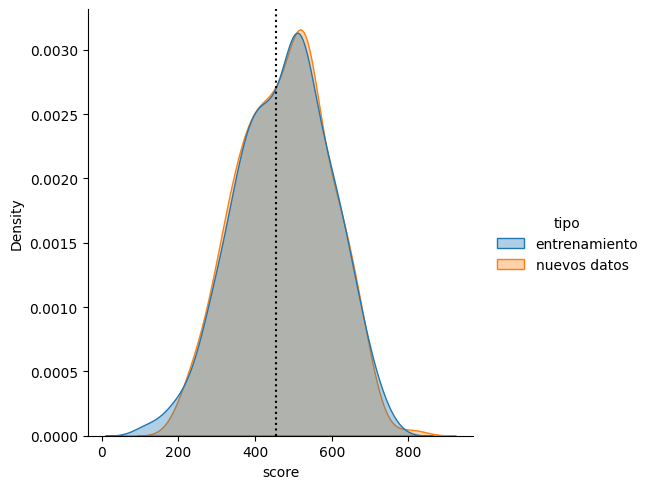

In [125]:


# ¿se distibuyen igual las probabilidades esperadas?
score_train = tarjeta.score(X)
score_nuevo = tarjeta.score(X_nuevo)

datos_score_psi1=pd.DataFrame(np.transpose([score_train,Y]), columns=['score','Y'])
datos_score_psi1['tipo']='entrenamiento'

datos_score_psi2=pd.DataFrame(np.transpose([score_nuevo,Y_nuevo]), columns=['score','Y'])
datos_score_psi2['tipo']='nuevos datos'

datos_score_psi= pd.concat([datos_score_psi1,datos_score_psi2])
sns.displot(data=datos_score_psi, x='score', label="event", hue='tipo', alpha=0.35,kind="kde", fill=True,common_norm=False)
plt.axvline(Score_Corte, color='k', linestyle=":")



In [126]:

# Estimo el psi
# Defino la tarjeta a evalear
# psi=ScorecardMonitoring(tarjeta, psi_method="cart",psi_min_bin_size=0.10, psi_n_bins=5)
psi=ScorecardMonitoring(tarjeta, psi_method= "quantile", psi_n_bins=3)




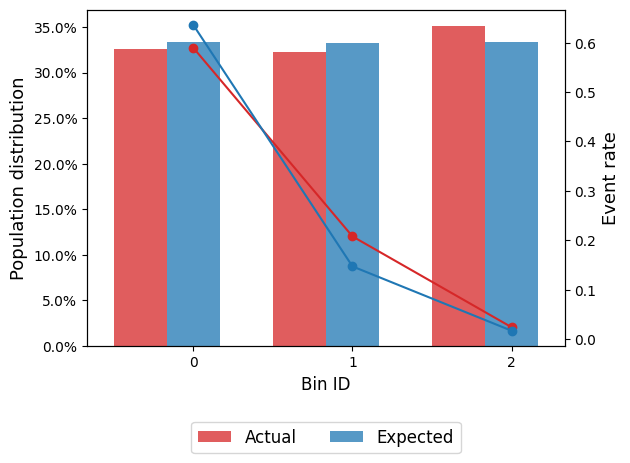

                     Bin  Count A  Count E  Count A (%)  Count E (%)       PSI
0         (-inf, 415.69)       78      239     0.326360     0.333799  0.000168
1       [415.69, 527.52)       77      238     0.322176     0.332402  0.000320
2          [527.52, inf)       84      239     0.351464     0.333799  0.000911
Totals                        239      716     1.000000     1.000000  0.001398
                Bin  Count A  Count E  Event rate A  Event rate E  statistic  p-value
0    (-inf, 415.69)       78      239      0.589744      0.635983   0.536252  0.46399
1  [415.69, 527.52)       77      238      0.207792      0.147059   1.581463  0.20855
2     [527.52, inf)       84      239      0.023810      0.016736   0.170566  0.67961


In [127]:
psi.fit(X_actual=X_nuevo, y_actual=Y_nuevo, X_expected=X, y_expected=Y)

psi.psi_plot()
print(psi.psi_table().to_string())
print(psi.tests_table().to_string())


In [128]:
psi.system_stability_report()

-----------------------------------
Monitoring: System Stability Report
-----------------------------------

  Population Stability Index (PSI)


    PSI total:      0.0014 (No significant change)

         PSI bin  Count  Count (%)
    [0.00, 0.10)      3        1.0
    [0.10, 0.25)      0        0.0
    [0.25, Inf+)      0        0.0

  Significance tests (H0: actual == expected)

     p-value bin  Count  Count (%)
    [0.00, 0.05)      0   0.000000
    [0.05, 0.10)      0   0.000000
    [0.10, 0.50)      2   0.666667
    [0.50, 1.00)      1   0.333333

  Target analysis

               Metric  Actual Actual (%)  Expected Expected (%)
    Number of records     239          -       716            -
        Event records      64   0.267782       191      0.26676
    Non-event records     175   0.732218       525      0.73324

  Performance metrics

                 Metric   Actual  Expected  Diff A - E
     True positive rate 0.515625  0.575916   -0.060291
     True negative rate 0.891

In [129]:
psi.psi_variable_table(style="summary").sort_values('PSI')

,Variable,PSI
7,other.debtors.or.guarantors,0.000366
4,housing,0.001543
5,installment.rate.in.percentage.of.disposable.i...,0.002413
9,present.employment.since,0.003205
1,credit.amount,0.004623
6,job,0.005851
2,credit.history,0.006243
12,savings.account.and.bonds,0.006991
8,other.installment.plans,0.015453
10,property,0.016466
